# Домашнее задание 3

У вас есть данные о полетах. Для каждого клиента известна краткая информация о самом человеке, о типе билета и о рейсе, а также оценки клиента различным аспектам полета.

Для некоторых клиентов известна их удовлетворенность полетом (satisfied или neutral or dissatisfied). По этим данным необходимо обучить модель, предсказывающую удовлетворенность клиентов полетом. Итоговые предсказания нужно сделать для клиентов, для которых ответ неизвестен.

Компания держит все данные в облаке Яндекса в Postgresql. Данные разбиты на смысловые таблицы. Чтобы получить данные, вам необходимо подключиться к базе данных и добыть оттуда данные.

Продуктивной и интересной вам работы!

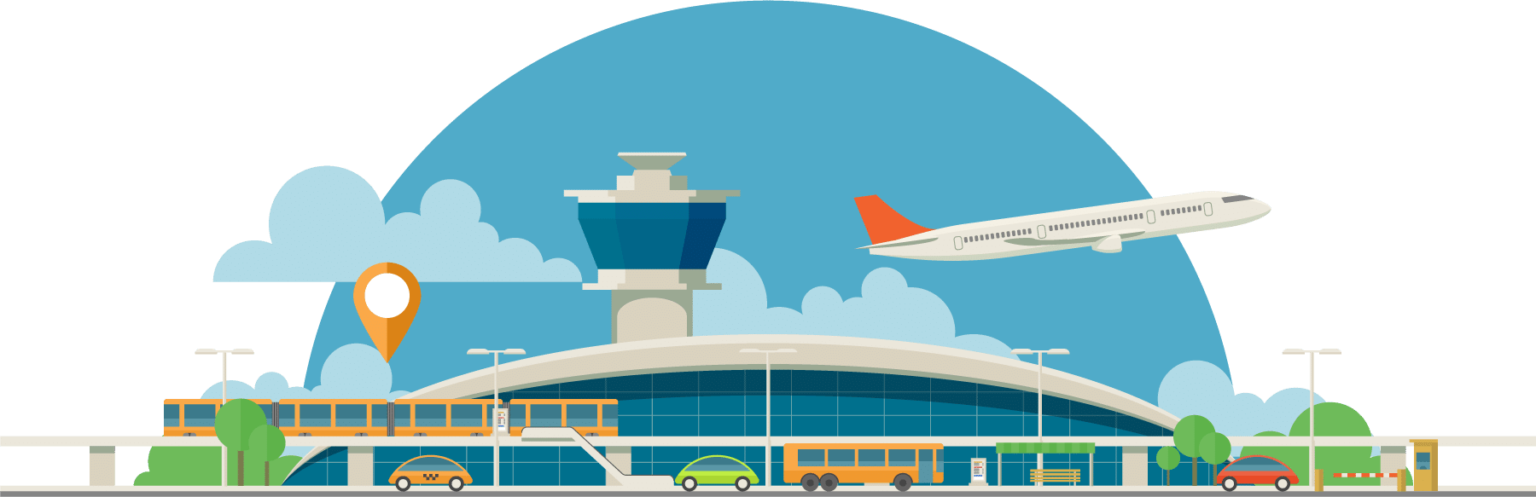

> Задания, <font color='#9933CC'>выделенные фиолетовым</font>, требуют от вас написания кода. <br/> А вопросы, <font color='#FF6600'>выделенные оранжевым</font>, -- текстового ответа.

Оцениваются как код, так и ответы на вопросы. Если нет одного и/или другого, то часть баллов за соответствующее задание без колебаний снимается.

Брать код из открытых источников позволительно. Следование культуре цитирования при этом обязательно

In [2]:
!pip install catboost
!pip install mlxtend --upgrade
!pip install optuna
!pip install lime
!pip install shap
!pip install missingno
!pip install psycopg2-binary
#!pip install xgboost
#!brew install cmake libomp
#!pip install lightgbm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 7.5 MB/s eta 0:00:00
  Attempting uninstall: mlxtend
    Found existing installation: mlxtend 0.22.0
    Uninstalling mlxtend-0.22.0:
      Successfully uninstalled mlxtend-0.22.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=294298016d3c180525dce9d6c83279ccdb634cd45ab8b3138b2a6d3ead9cb4c1
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import missingno

import psycopg2
import psycopg2.extras

from mlxtend.plotting import plot_decision_regions
from mlxtend.evaluate import bias_variance_decomp
from graphviz import Source
from sklearn.tree import export_graphviz
from IPython.display import SVG

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, StandardScaler
from sklearn.calibration import CalibrationDisplay
from sklearn.isotonic import IsotonicRegression

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.feature_selection import VarianceThreshold, SelectKBest, chi2, mutual_info_classif
from sklearn.feature_selection import SequentialFeatureSelector, RFE, SelectFromModel
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator

import shap
import lime
import lime.lime_tabular

import optuna

import pickle

np.random.seed(42)


In [4]:
pd.set_option('display.max_columns', None)

# Data Prep & EDA (3 балла)

## Загрузка и предобработка данных (1.75 балла)

In [5]:
!mkdir -p ~/.postgresql && \
wget "https://storage.yandexcloud.net/cloud-certs/CA.pem" \
    --output-document ~/.postgresql/root.crt && \
chmod 0600 ~/.postgresql/root.crt

--2023-12-30 15:06:14--  https://storage.yandexcloud.net/cloud-certs/CA.pem
Resolving storage.yandexcloud.net (storage.yandexcloud.net)... 213.180.193.243, 2a02:6b8::1d9
Connecting to storage.yandexcloud.net (storage.yandexcloud.net)|213.180.193.243|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3579 (3.5K) [application/x-x509-ca-cert]
Saving to: ‘/root/.postgresql/root.crt’

/root/.postgresql/r 100%[===================>]   3.50K  --.-KB/s    in 0s      

2023-12-30 15:06:15 (2.61 GB/s) - ‘/root/.postgresql/root.crt’ saved [3579/3579]



(0.5 балла) <font color='#9933CC'>Подключитесь к БД при помощи `psycopg2.connect()` и напишите SQL-запрос, объединяющий 3 нужные таблицы в одну</font>.
Список столбцов таблиц добудьте самостоятельно.

<font color='#9933CC'>Результат запроса поместите в `pd.DataFrame`. Индексом получившегося датафрейма сделайте столбец 'id'</font>

> Не забудьте закрыть соединение. Или открывайте соединение, используя менеджер контекста `with as`, который закроет его автоматически

### Параметры соединения
```
host=rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net
port=6432
sslmode=verify-full
dbname=db_flights
user=mlhs_student
password=mlhs_student
target_session_attrs=read-write
```

### Схема БД

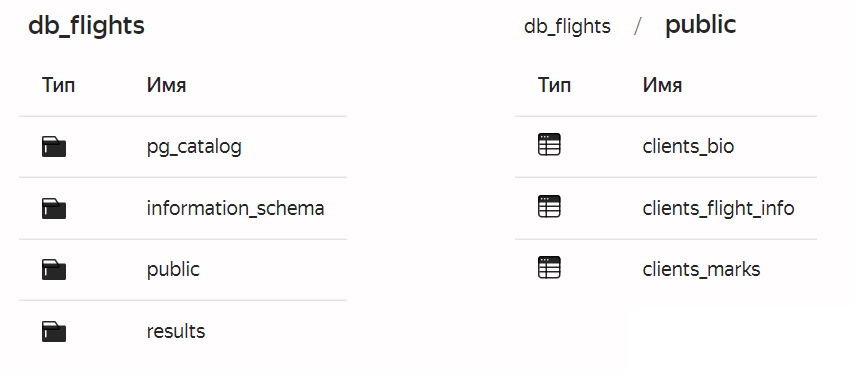

In [6]:
with psycopg2.connect(
    host='rc1b-70q90cunwkzx49mj.mdb.yandexcloud.net',
    port=6432, sslmode='verify-full',
    dbname='db_flights',
    user='mlhs_student',
    password='mlhs_student',
    target_session_attrs='read-write'
    ) as connection:
    clients = pd.read_sql('select * from public.clients_bio',
            con=connection,
            index_col='id')

    fl_info = pd.read_sql('select * from public.clients_flight_info',
            con=connection,
            index_col='id')

    marks = pd.read_sql('select * from public.clients_marks',
            con=connection,
            index_col='id')

pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.


In [7]:
clients.head(3)

gender   age
id              
1     Male  48.0
2   Female  35.0
3     Male  41.0

In [8]:
fl_info.head(3)

Customer Type   Type of Travel     class Flight Distance  \
id                                                                 
1   disloyal Customer  Business travel  Business           821.0   
2      Loyal Customer  Business travel  Business           821.0   
3      Loyal Customer  Business travel  Business           853.0   

   Departure Delay in Minutes Arrival Delay in Minutes  
id                                                      
1                         2.0                      5.0  
2                        26.0                     39.0  
3                         0.0                      0.0

In [9]:
marks.head(3)

Inflight wifi service Departure/Arrival time convenient  \
id                                                           
1                    3.0                               3.0   
2                    2.0                               2.0   
3                    4.0                               4.0   

   Ease of Online booking Gate location Food and drink Online boarding  \
id                                                                       
1                     3.0           3.0            5.0             3.0   
2                     2.0           2.0            3.0             5.0   
3                     4.0           4.0            5.0             5.0   

   Seat comfort Inflight entertainment On-board service Leg room service  \
id                                                                         
1           5.0                    5.0              3.0              2.0   
2           4.0                    5.0              5.0              5.0   
3           5.0                    3.0              3.0              3.0   

   Baggage handling Checkin service Inflight service cleanliness  \
id                                                                 
1               5.0             4.0              5.0         5.0   
2               5.0             3.0              5.0         5.0   
3               3.0             4.0              3.0         5.0   

               satisfaction  
id                           
1   neutral or dissatisfied  
2                 satisfied  
3                 satisfied

In [10]:
df = (
    clients
    .join(fl_info)
    .join(marks)
)

In [11]:
df.head(3)

gender   age      Customer Type   Type of Travel     class  \
id                                                               
1     Male  48.0  disloyal Customer  Business travel  Business   
2   Female  35.0     Loyal Customer  Business travel  Business   
3     Male  41.0     Loyal Customer  Business travel  Business   

   Flight Distance Departure Delay in Minutes Arrival Delay in Minutes  \
id                                                                       
1            821.0                        2.0                      5.0   
2            821.0                       26.0                     39.0   
3            853.0                        0.0                      0.0   

   Inflight wifi service Departure/Arrival time convenient  \
id                                                           
1                    3.0                               3.0   
2                    2.0                               2.0   
3                    4.0                               4.0   

   Ease of Online booking Gate location Food and drink Online boarding  \
id                                                                       
1                     3.0           3.0            5.0             3.0   
2                     2.0           2.0            3.0             5.0   
3                     4.0           4.0            5.0             5.0   

   Seat comfort Inflight entertainment On-board service Leg room service  \
id                                                                         
1           5.0                    5.0              3.0              2.0   
2           4.0                    5.0              5.0              5.0   
3           5.0                    3.0              3.0              3.0   

   Baggage handling Checkin service Inflight service cleanliness  \
id                                                                 
1               5.0             4.0              5.0         5.0   
2               5.0             3.0              5.0         5.0   
3               3.0             4.0              3.0         5.0   

               satisfaction  
id                           
1   neutral or dissatisfied  
2                 satisfied  
3                 satisfied

In [12]:
assert df.shape == (129_549, 23)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129549 entries, 1 to 129880
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   gender                             129549 non-null  object
 1   age                                129549 non-null  object
 2   Customer Type                      129549 non-null  object
 3   Type of Travel                     129549 non-null  object
 4   class                              129549 non-null  object
 5   Flight Distance                    129549 non-null  object
 6   Departure Delay in Minutes         129549 non-null  object
 7   Arrival Delay in Minutes           129549 non-null  object
 8   Inflight wifi service              129549 non-null  object
 9   Departure/Arrival time convenient  129549 non-null  object
 10  Ease of Online booking             129549 non-null  object
 11  Gate location                      129549 non-null  

(0.25 балла) <font color='#9933CC'>Преобразуйте числовые столбцы в `float`. Проверьте, есть ли в датафрейме пропуски и выбросы (в том числе в категориальных признаках)</font>.

In [14]:
# your code below
num_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes',
            'Arrival Delay in Minutes', 'Inflight wifi service',
            'Departure/Arrival time convenient', 'Ease of Online booking',
            'Gate location', 'Food and drink', 'Online boarding',
            'Seat comfort', 'Inflight entertainment', 'On-board service',
            'Leg room service', 'Baggage handling', 'Checkin service',
            'Inflight service', 'cleanliness']
cat_cols = ['gender', 'Customer Type', 'Type of Travel', 'class', 'satisfaction']

In [15]:
print(len(num_cols))
print(len(cat_cols))

18
5


In [16]:
df[num_cols] = df[num_cols].astype(float)

In [17]:
# пропуски есть
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129549 entries, 1 to 129880
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129549 non-null  object 
 3   Type of Travel                     129549 non-null  object 
 4   class                              129549 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      1295

In [18]:
df['gender'].value_counts()

Female    65726
Male      63823
Name: gender, dtype: int64

In [19]:
# видим, что есть текстовый nan
df['Customer Type'].value_counts()

Loyal Customer       105763
disloyal Customer     23709
nan                      77
Name: Customer Type, dtype: int64

In [20]:
df['Type of Travel'].value_counts()

Business travel    89405
Personal Travel    40043
nan                  101
Name: Type of Travel, dtype: int64

In [21]:
df['class'].value_counts()

Business    61939
Eco         58115
Eco Plus     9379
nan           116
Name: class, dtype: int64

In [22]:
df['satisfaction'].value_counts()

neutral or dissatisfied    58732
satisfied                  44912
-                          25905
Name: satisfaction, dtype: int64

In [23]:
for col in cat_cols:
    df.loc[df[col] == 'nan', col] = np.nan

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129549 entries, 1 to 129880
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   gender                             129549 non-null  object 
 1   age                                129234 non-null  float64
 2   Customer Type                      129472 non-null  object 
 3   Type of Travel                     129448 non-null  object 
 4   class                              129433 non-null  object 
 5   Flight Distance                    129455 non-null  float64
 6   Departure Delay in Minutes         129442 non-null  float64
 7   Arrival Delay in Minutes           129042 non-null  float64
 8   Inflight wifi service              129505 non-null  float64
 9   Departure/Arrival time convenient  129500 non-null  float64
 10  Ease of Online booking             129506 non-null  float64
 11  Gate location                      1295

In [25]:
df.describe()

age  Flight Distance  Departure Delay in Minutes  \
count  129234.000000    129455.000000               129442.000000   
mean       40.116951      1322.922158                   15.809026   
std        20.376129      4517.816532                   93.276882   
min         0.000000         0.000000                    0.000000   
25%        27.000000       414.000000                    0.000000   
50%        40.000000       846.000000                    0.000000   
75%        51.000000      1744.000000                   12.000000   
max       621.000000    379620.000000                22227.000000   

       Arrival Delay in Minutes  Inflight wifi service  \
count             129042.000000          129505.000000   
mean                  16.656499               2.732327   
std                  109.285072               1.360033   
min                    0.000000               0.000000   
25%                    0.000000               2.000000   
50%                    0.000000               3.000000   
75%                   13.000000               4.000000   
max                14006.000000              45.000000   

       Departure/Arrival time convenient  Ease of Online booking  \
count                      129500.000000           129506.000000   
mean                            3.062131                2.760722   
std                             1.559627                1.431048   
min                             0.000000                0.000000   
25%                             2.000000                2.000000   
50%                             3.000000                3.000000   
75%                             4.000000                4.000000   
max                            45.000000               45.000000   

       Gate location  Food and drink  Online boarding   Seat comfort  \
count  129512.000000   129499.000000    129503.000000  129502.000000   
mean        2.981708        3.208141         3.256782       3.445669   
std         1.312873        1.357546         1.381888       1.349713   
min         0.000000        0.000000         0.000000       0.000000   
25%         2.000000        2.000000         2.000000       2.000000   
50%         3.000000        3.000000         3.000000       4.000000   
75%         4.000000        4.000000         4.000000       5.000000   
max        36.000000       45.000000        40.000000      45.000000   

       Inflight entertainment  On-board service  Leg room service  \
count           129504.000000     129505.000000     129503.000000   
mean                 3.361232          3.387259          3.355976   
std                  1.366908          1.335697          1.361670   
min                  0.000000          0.000000          0.000000   
25%                  2.000000          2.000000          2.000000   
50%                  4.000000          4.000000          4.000000   
75%                  4.000000          4.000000          4.000000   
max                 45.000000         45.000000         40.000000   

       Baggage handling  Checkin service  Inflight service    cleanliness  
count     129501.000000    129507.000000     129486.000000  129512.000000  
mean           3.635872         3.309976          3.646927       3.289780  
std            1.222039         1.298827          1.218748       1.347466  
min            0.000000         0.000000          0.000000       0.000000  
25%            3.000000         3.000000          3.000000       2.000000  
50%            4.000000         3.000000          4.000000       3.000000  
75%            5.000000         4.000000          5.000000       4.000000  
max           40.000000        45.000000         40.000000      45.000000

In [26]:
def find_outliers(df, numeric_cols, sigmas):
    '''
    return dict: {all_info_dict: {lower_treshold: float, upper_treshold: float, cnt_outliers: int}, plot_df: pd.DataFrame}
    '''
    feat_dict = dict()
    plot_dict = dict()
    cnt_col = list()
    feat_col = list()
    for col in numeric_cols:
        info_dict = dict()
        std = df.std()[col]
        upper_treshold = sigmas * std
        lower_treshold = -sigmas * std
        outliers_df = df.loc[
            (df[col] >= upper_treshold) | (df[col] <= lower_treshold),
            col]
        cnt_outliers = outliers_df.count()
        info_dict['lower_treshold'] = lower_treshold
        info_dict['upper_treshold'] = upper_treshold
        info_dict['cnt_outliers'] = cnt_outliers
        feat_dict[col] = info_dict
        feat_col.append(col)
        cnt_col.append(cnt_outliers)

    plot_dict['features'] = feat_col
    plot_dict['cnt_outliers'] = cnt_col

    return {
        'all_info_dict': feat_dict,
        'plot_df': pd.DataFrame.from_dict(data=plot_dict)
        }

In [27]:
# выбросы по z-оценкам (+-3 sigmas)
outliers_in_df = find_outliers(df, num_cols, 3)

The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value o

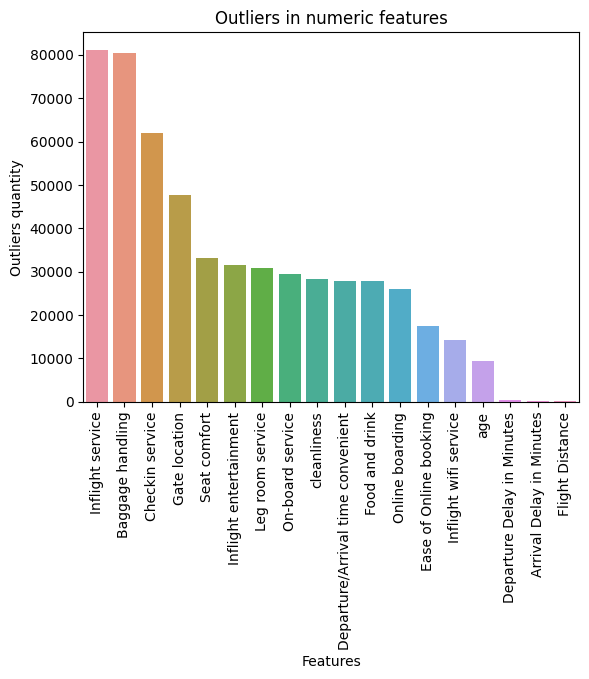

In [28]:
ax = sns.barplot(
    data=outliers_in_df['plot_df'].sort_values(by='cnt_outliers', ascending=False),
    x='features',
    y='cnt_outliers'
    )

plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Outliers quantity')
plt.title('Outliers in numeric features')

plt.show()

(0.5 балла) <font color='#9933CC'>Воспользуйтесь модулем `missingno` для визуализации пропусков в датафрейме</font>

Нас интересует `matrix` пропущенных значений и столбцатая диаграмма в логарифмированной шкале (*пропусков немного => по обычной не будет видно, в каких столбцах их больше*)

<Axes: >

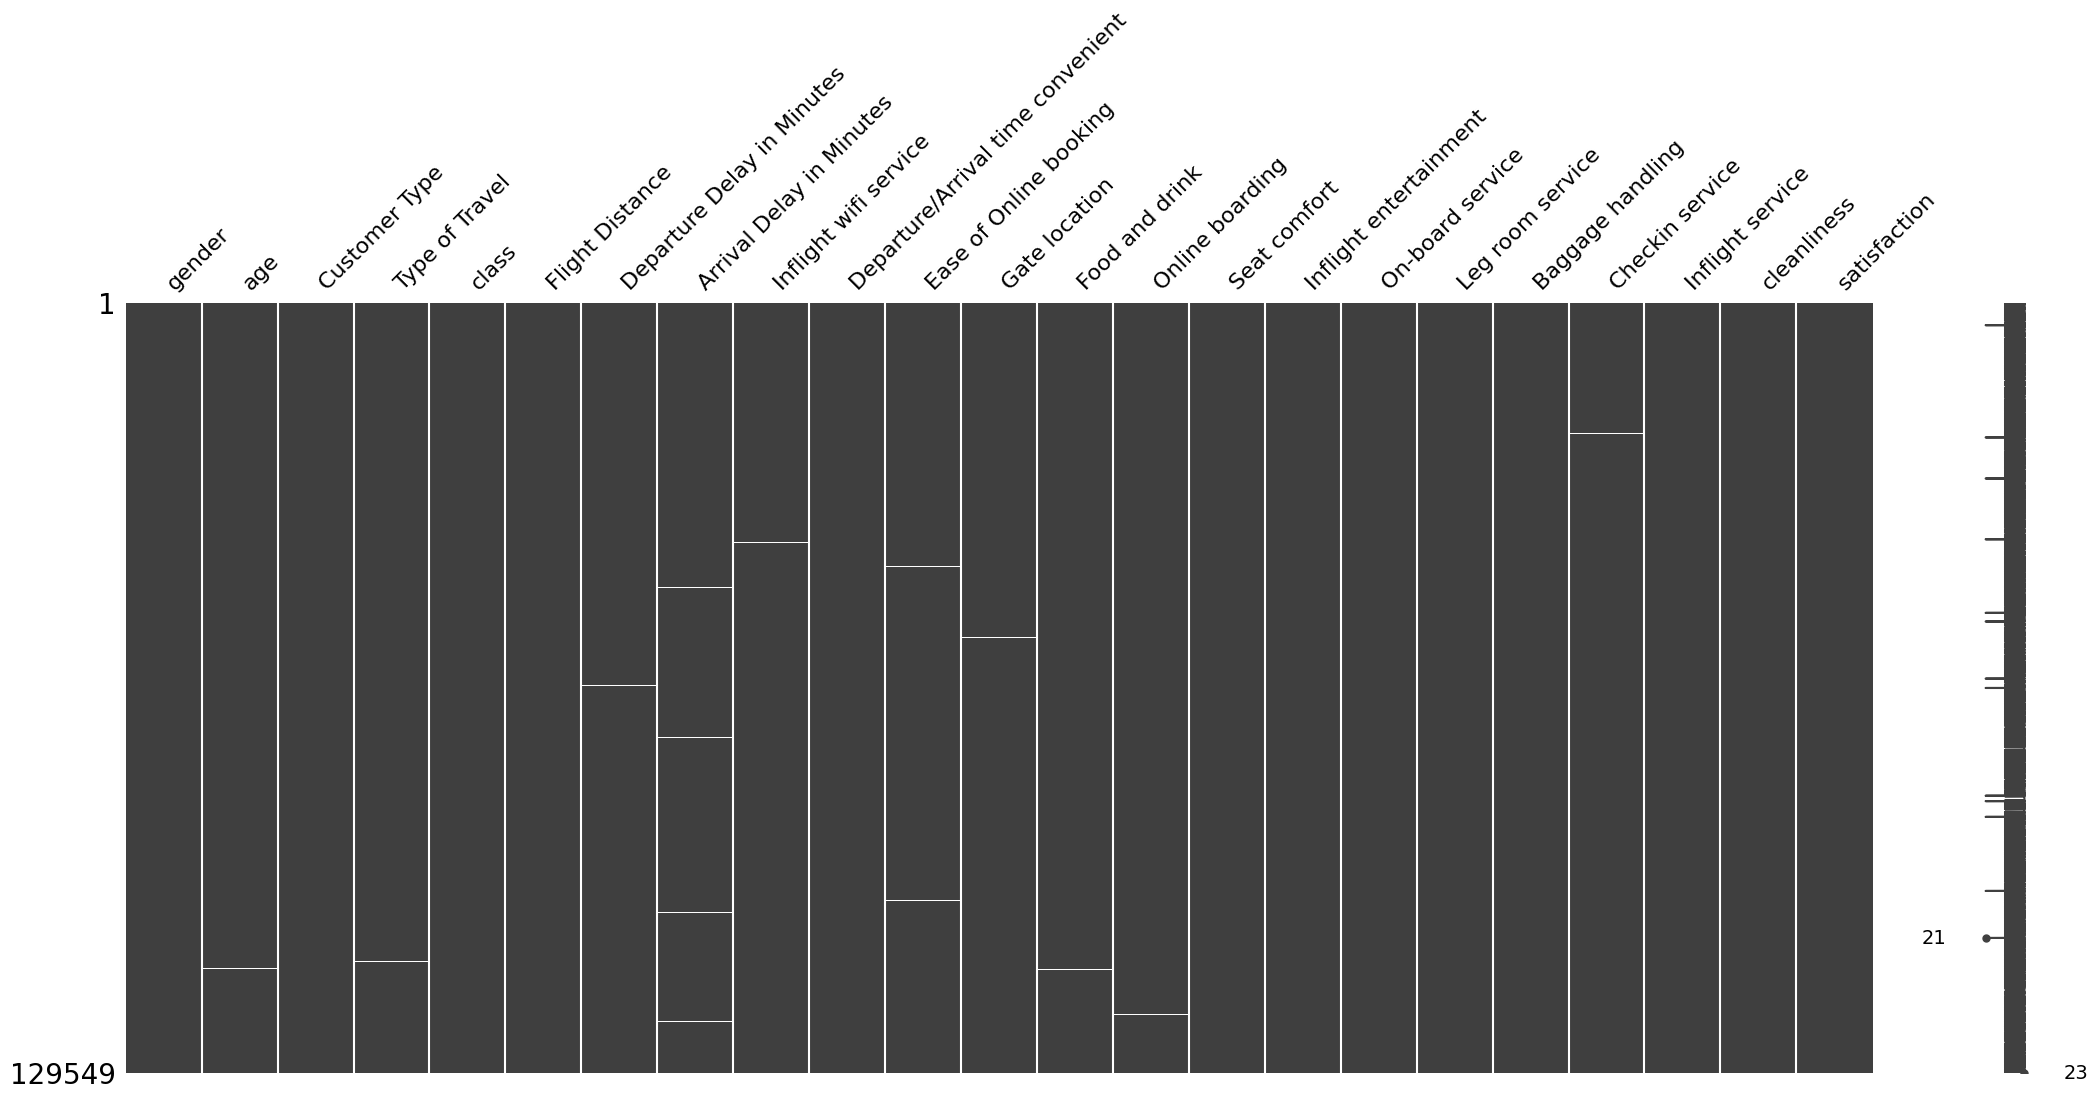

In [29]:
# your code below
missingno.matrix(df)

FixedFormatter should only be used together with FixedLocator


<Axes: >

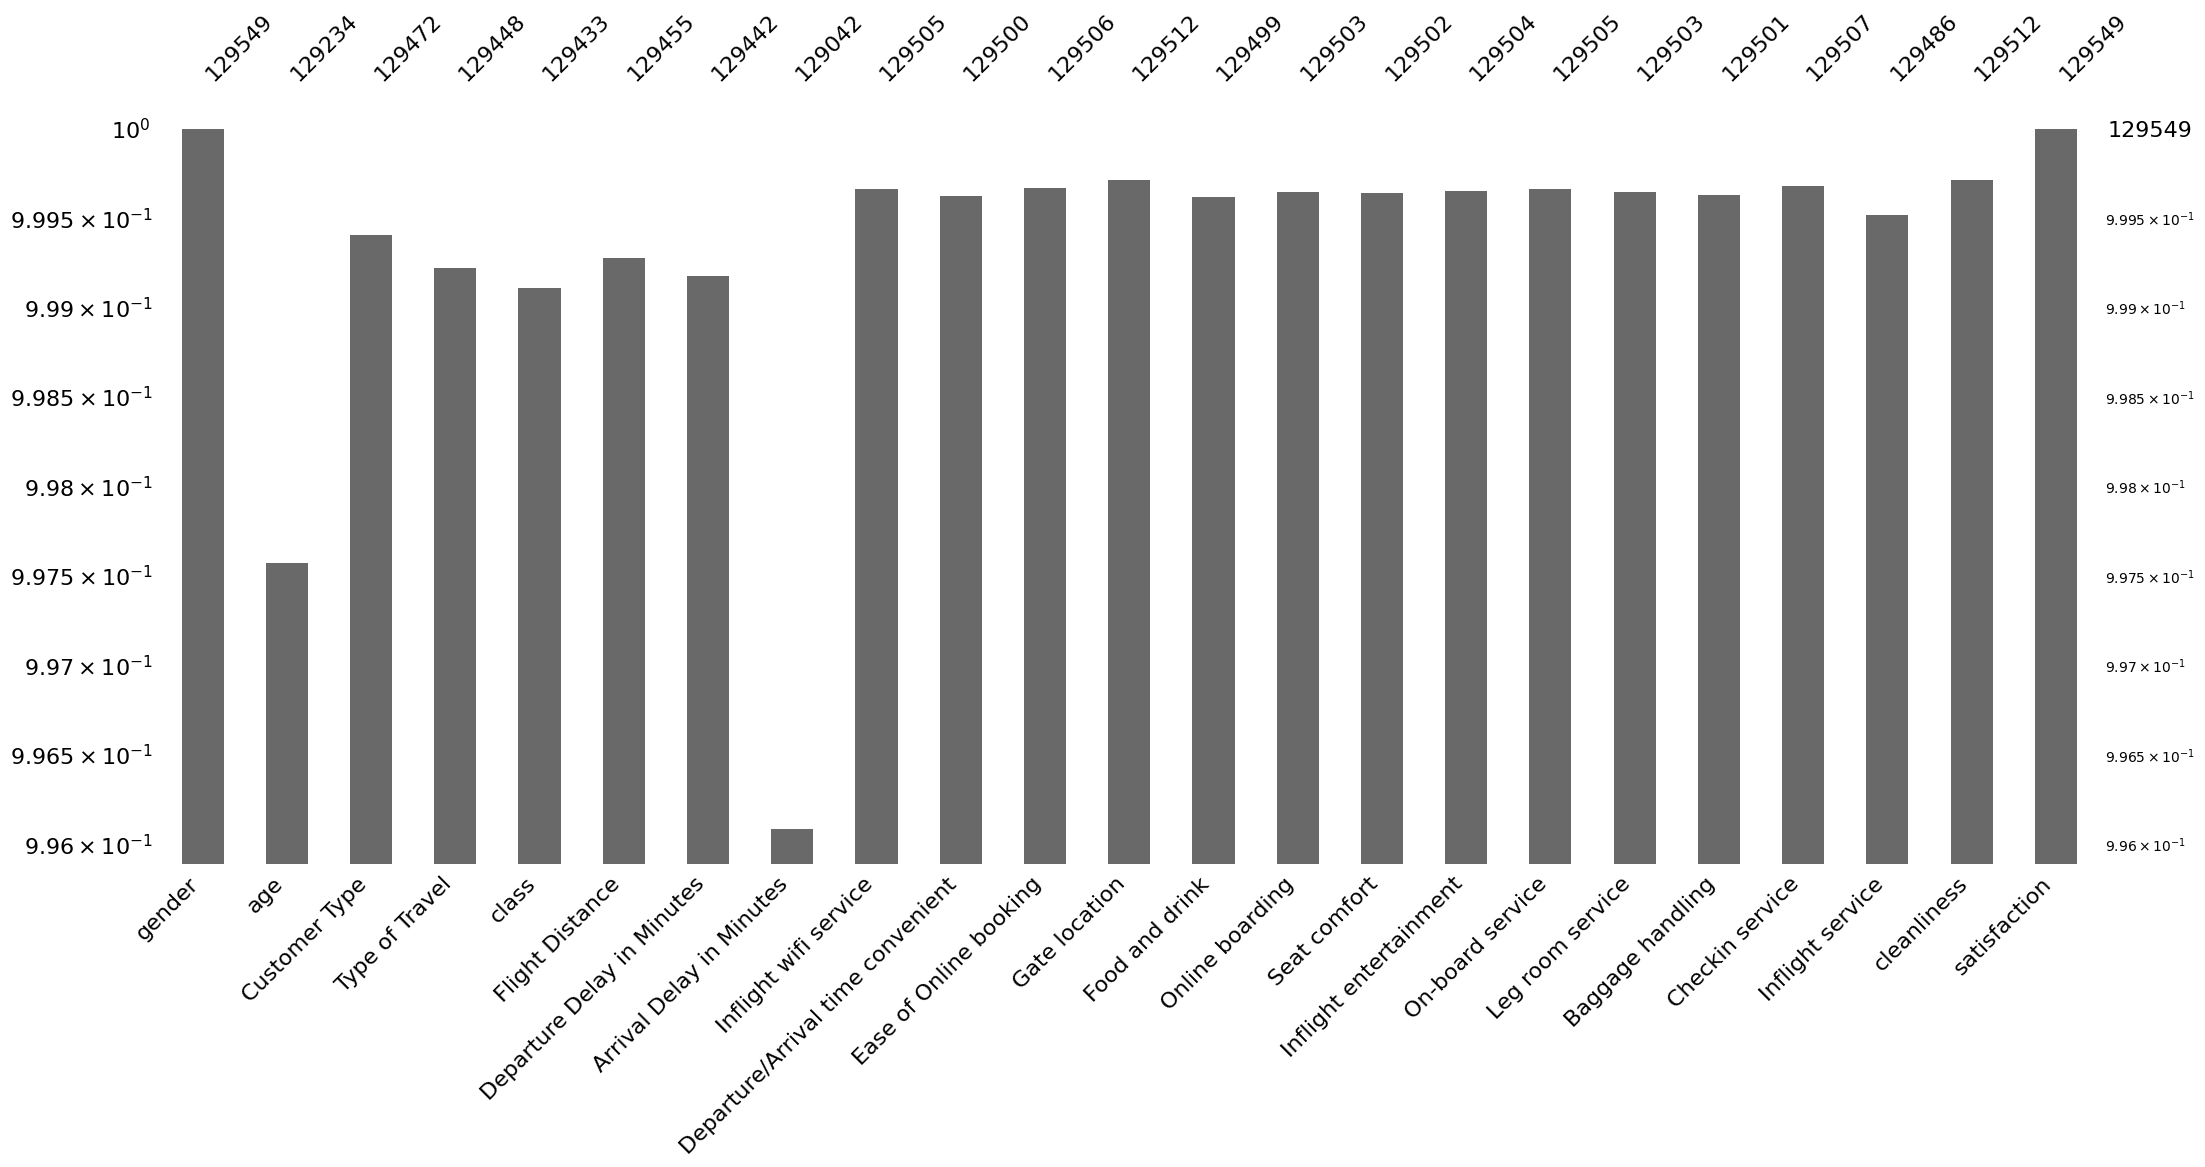

In [30]:
# your code below
missingno.bar(df, log=True)

Разобьем датасет на тренировочную и тестовую части. Тестовую часть отложим надолго -- до самого конца этого ноутбука

In [290]:
df_train = df[df.satisfaction != '-']
df_train

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
1         Male  48.0  disloyal Customer  Business travel  Business   
2       Female  35.0     Loyal Customer  Business travel  Business   
3         Male  41.0     Loyal Customer  Business travel  Business   
4         Male  50.0     Loyal Customer  Business travel  Business   
5       Female  49.0     Loyal Customer  Business travel  Business   
...        ...   ...                ...              ...       ...   
129874  Female  28.0     Loyal Customer  Personal Travel  Eco Plus   
129875  Female  55.0     Loyal Customer  Personal Travel  Eco Plus   
129878    Male  42.0     Loyal Customer  Personal Travel  Eco Plus   
129879    Male  50.0     Loyal Customer  Personal Travel  Eco Plus   
129880  Female  20.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
1                 821.0                         2.0                       5.0   
2                 821.0                        26.0                      39.0   
3                 853.0                         0.0                       0.0   
4                1905.0                         0.0                       0.0   
5                3470.0                         0.0                       1.0   
...                 ...                         ...                       ...   
129874            337.0                         0.0                       0.0   
129875            308.0                         0.0                       0.0   
129878            337.0                         6.0                      14.0   
129879            337.0                        31.0                      22.0   
129880            337.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
1                         3.0                                3.0   
2                         2.0                                2.0   
3                         4.0                                4.0   
4                         2.0                                2.0   
5                         3.0                                3.0   
...                       ...                                ...   
129874                    4.0                                2.0   
129875                    3.0                                4.0   
129878                    2.0                                5.0   
129879                    5.0                                4.0   
129880                    3.0                                1.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
1                          3.0            3.0             5.0   
2                          2.0            2.0             3.0   
3                          4.0            4.0             5.0   
4                          2.0            2.0             4.0   
5                          3.0            3.0             4.0   
...                        ...            ...             ...   
129874                     4.0            4.0             3.0   
129875                     3.0            4.0             2.0   
129878                     2.0            1.0             3.0   
129879                     4.0            1.0             3.0   
129880                     3.0            2.0             2.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
1                   3.0           5.0                     5.0   
2                   5.0           4.0                     5.0   
3                   5.0           5.0               

In [291]:
assert df_train.shape == (103_644, 23)

In [292]:
df_test = df[df.satisfaction == '-'].drop('satisfaction', axis=1)
df_test

gender   age      Customer Type   Type of Travel     class  \
id                                                                   
17      Female  48.0     Loyal Customer  Personal Travel       Eco   
20      Female  42.0     Loyal Customer  Personal Travel       Eco   
35        Male  39.0     Loyal Customer  Business travel  Business   
44        Male  51.0     Loyal Customer  Business travel  Business   
49        Male  20.0  disloyal Customer  Business travel       Eco   
...        ...   ...                ...              ...       ...   
129847  Female  16.0     Loyal Customer  Personal Travel       Eco   
129868    Male  47.0     Loyal Customer  Business travel  Eco Plus   
129872  Female  32.0     Loyal Customer  Business travel  Eco Plus   
129876    Male  28.0     Loyal Customer  Personal Travel  Eco Plus   
129877    Male  41.0     Loyal Customer  Personal Travel  Eco Plus   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
id                                                                              
17                821.0                         0.0                       0.0   
20                821.0                         4.0                       0.0   
35               1672.0                        23.0                      17.0   
44               2077.0                         0.0                       1.0   
49                108.0                         0.0                      29.0   
...                 ...                         ...                       ...   
129847            337.0                         0.0                       0.0   
129868            447.0                         0.0                       0.0   
129872            337.0                         0.0                       1.0   
129876            447.0                         2.0                       3.0   
129877            308.0                         0.0                       0.0   

        Inflight wifi service  Departure/Arrival time convenient  \
id                                                                 
17                        2.0                                3.0   
20                        3.0                                3.0   
35                        2.0                                2.0   
44                        4.0                                1.0   
49                        4.0                                5.0   
...                       ...                                ...   
129847                    0.0                                4.0   
129868                    3.0                                4.0   
129872                    4.0                                2.0   
129876                    4.0                                4.0   
129877                    3.0                                5.0   

        Ease of Online booking  Gate location  Food and drink  \
id                                                              
17                         2.0            3.0             1.0   
20                         3.0            4.0             1.0   
35                         2.0            2.0             5.0   
44                         4.0            4.0             2.0   
49                         4.0            1.0             5.0   
...                        ...            ...             ...   
129847                     0.0            5.0             3.0   
129868                     4.0            4.0             4.0   
129872                     4.0            2.0             4.0   
129876                     4.0            2.0             4.0   
129877                     3.0            4.0             2.0   

        Online boarding  Seat comfort  Inflight entertainment  \
id                                                              
17                  5.0           1.0                     5.0   
20                  3.0           4.0                     1.0   
35                  4.0           5.0               

In [293]:
assert df_test.shape == (25_905, 22)

Разбиваем данные на трейн и валидацию. Не меняйте сид

In [294]:
X_train, X_val, y_train, y_val = train_test_split(df_train.drop('satisfaction', axis=1), df_train.satisfaction, test_size=0.3, random_state=42)

In [295]:
assert X_train.shape == (72_550, 22)
assert X_val.shape == (31_094, 22)

(0.25 балла) <font color='#9933CC'>Заполните пропуски в данных наиболее часто встречающимся значением</font>.
Обратите внимание, что правильная стратегия заполнения пропусков выглядит так:

* посчитать моды для `X_train`
* ими заполнить пропуски в `X_train`, `X_val` и `df_test`

Было бы неплохо воспользоваться другой стратегией: восстановать пропуски `KNNImputer`'ом или `IterativeImputer`'ом. Но для признаков в нашей задаче они в чистом виде бы, увы, скорее, не подошли. Импьютеры возвращали бы вещественные значения, а в нашей задаче все признаки целые.

В общем, для изящного и удобного для применения в пайплайне заполнения пропусков, пришлось бы кодить самописные классы. Этим можете заняться в бонусной части.

In [296]:
# your code below
fill_na_dict = dict()

for key, value in X_train.mode().to_dict(orient='dict').items():
    fill_na_dict[key] = value[0]

In [297]:
X_train = X_train.fillna(fill_na_dict)
X_val = X_val.fillna(fill_na_dict)
df_test = df_test.fillna(fill_na_dict)

In [298]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72550 entries, 32806 to 19805
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             72550 non-null  object 
 1   age                                72550 non-null  float64
 2   Customer Type                      72550 non-null  object 
 3   Type of Travel                     72550 non-null  object 
 4   class                              72550 non-null  object 
 5   Flight Distance                    72550 non-null  float64
 6   Departure Delay in Minutes         72550 non-null  float64
 7   Arrival Delay in Minutes           72550 non-null  float64
 8   Inflight wifi service              72550 non-null  float64
 9   Departure/Arrival time convenient  72550 non-null  float64
 10  Ease of Online booking             72550 non-null  float64
 11  Gate location                      72550 non-null 

In [299]:
X_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31094 entries, 24136 to 80316
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             31094 non-null  object 
 1   age                                31094 non-null  float64
 2   Customer Type                      31094 non-null  object 
 3   Type of Travel                     31094 non-null  object 
 4   class                              31094 non-null  object 
 5   Flight Distance                    31094 non-null  float64
 6   Departure Delay in Minutes         31094 non-null  float64
 7   Arrival Delay in Minutes           31094 non-null  float64
 8   Inflight wifi service              31094 non-null  float64
 9   Departure/Arrival time convenient  31094 non-null  float64
 10  Ease of Online booking             31094 non-null  float64
 11  Gate location                      31094 non-null 

In [300]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25905 entries, 17 to 129877
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             25905 non-null  object 
 1   age                                25905 non-null  float64
 2   Customer Type                      25905 non-null  object 
 3   Type of Travel                     25905 non-null  object 
 4   class                              25905 non-null  object 
 5   Flight Distance                    25905 non-null  float64
 6   Departure Delay in Minutes         25905 non-null  float64
 7   Arrival Delay in Minutes           25905 non-null  float64
 8   Inflight wifi service              25905 non-null  float64
 9   Departure/Arrival time convenient  25905 non-null  float64
 10  Ease of Online booking             25905 non-null  float64
 11  Gate location                      25905 non-null  f

<font color='#9933CC'>Выведите основные статистики по числовым и категориальным столбцам таблицы `X_train`</font>

In [301]:
# the place for you to code

X_train.describe(include='all')

gender           age   Customer Type   Type of Travel     class  \
count    72550  72550.000000           72550            72550     72550   
unique       2           NaN               2                2         3   
top     Female           NaN  Loyal Customer  Business travel  Business   
freq     36738           NaN           59364            50046     34639   
mean       NaN     40.083666             NaN              NaN       NaN   
std        NaN     20.355546             NaN              NaN       NaN   
min        NaN      0.000000             NaN              NaN       NaN   
25%        NaN     27.000000             NaN              NaN       NaN   
50%        NaN     40.000000             NaN              NaN       NaN   
75%        NaN     51.000000             NaN              NaN       NaN   
max        NaN    612.000000             NaN              NaN       NaN   

        Flight Distance  Departure Delay in Minutes  Arrival Delay in Minutes  \
count      72550.000000                72550.000000              72550.000000   
unique              NaN                         NaN                       NaN   
top                 NaN                         NaN                       NaN   
freq                NaN                         NaN                       NaN   
mean        1338.222261                   15.642591                 16.381116   
std         4838.640464                   67.829985                100.546087   
min            0.000000                    0.000000                  0.000000   
25%          413.000000                    0.000000                  0.000000   
50%          842.000000                    0.000000                  0.000000   
75%         1744.000000                   12.000000                 13.000000   
max       328510.000000                 9282.000000              14006.000000   

        Inflight wifi service  Departure/Arrival time convenient  \
count            72550.000000                       72550.000000   
unique                    NaN                                NaN   
top                       NaN                                NaN   
freq                      NaN                                NaN   
mean                 2.735603                           3.063556   
std                  1.366913                           1.556199   
min                  0.000000                           0.000000   
25%                  2.000000                           2.000000   
50%                  3.000000                           3.000000   
75%                  4.000000                           4.000000   
max                 45.000000                          45.000000   

        Ease of Online booking  Gate location  Food and drink  \
count             72550.000000   72550.000000    72550.000000   
unique                     NaN            NaN             NaN   
top                        NaN            NaN             NaN   
freq                       NaN            NaN             NaN   
mean                  2.760744       2.981792        3.208132   
std                   1.416293       1.302569        1.357203   
min                   0.000000       0.000000        0.000000   
25%                   2.000000       2.000000        2.000000   
50%                   3.000000       3.000000        3.000000   
75%                   4.000000       4.000000        4.000000   
max                  36.000000      36.000000       45.000000   

        Online boarding  Seat comfort  Inflight entertainment  \
count      72550.000000  72550.000000            72550.000000   
unique              NaN           NaN                     NaN   
top                 NaN           NaN                     NaN   
freq                NaN           NaN                     NaN   
mean           3.259821      3.444328                3.362660   
std            1.393320      1.344373                1.368691   
min            0.000000      0.000000                0.000000   
25%            2

<font color='#FF6600'>Что вы можете сказать про распределение значений признаков?</font>

__Ответ:__  

Распределение числовых признаков похоже на нормальное, медиана и среднее почти равны.

In [302]:
# answer here, feel free to change into markdown

(0.25 балла) <font color='#9933CC'>Удалите строки c выбросами в числовых столбцах</font> (для трейна и валидации; тест оставьте без изменений). Выбросами считайте значения признака, строго превышающие 0.996-квантиль


---
<br/>

*Откуда взялся именно 0.996-квантиль?*

*В рамках анализа данных на выборсы вы вполне могли заметить, какие значения признаков встречаются редко. В среднем для всех признаков эти значения начинаются ~в этом квантиле*

In [303]:
# place for you to code

def find_outliers_quantile(df, quantile):
    tresholders_dict = df.quantile(quantile).to_dict()
    return tresholders_dict

def drop_rows_outliers(df, quantile):
    drop_values_dict = find_outliers_quantile(df, quantile)
    df_dropped = df.copy()
    for col, treshold in drop_values_dict.items():
        df_dropped = df_dropped[df_dropped[col] <= treshold]

    return df_dropped

In [304]:
X_train = drop_rows_outliers(X_train, 0.996)
X_val = drop_rows_outliers(X_val, 0.996)

The default value of numeric_only in DataFrame.quantile is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [305]:
assert X_train.shape == (71_369, 22) # эти ассерты у большинства студентов не проходили
assert X_val.shape == (30_609, 22) # и это совершенно не принципиально
assert df_test.shape == (25_905, 22)

In [309]:
y_train = X_train.join(y_train)['satisfaction'].reset_index(drop=True)
y_val = X_val.join(y_val)['satisfaction'].reset_index(drop=True)
X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)

## EDA (1.25 балла)

Создадим переменные с перечислениями столбцов разного типа

In [310]:
continuous_cols = ['age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
ordinal_cols = list(set(df.select_dtypes(include='number').columns) - set(continuous_cols))
categorical_cols = list(df.select_dtypes(include='object').columns)[:-1]

In [311]:
assert len(continuous_cols + ordinal_cols + categorical_cols) == 22

(0.5 балла) <font color='#9933CC'>Напишите процедуры для отрисовки графиков</font>

* Для признаков, которые мы выделили как порядковые, отображайте только `countplot`
* Для тех, что считаем континуальными, -- гистограмму распределения признака и ящик с усами (inline)
* Для категориальных -- только `countplot`

Обязательно выделяйте таргет разными цветами. Мы же хотим в конечном итоге понять, чем удовлетворенные клиенты отличаются от недовольных.

> Все графики и их оси обязательно должны быть подписаны, легенда на графике также необходима

In [312]:
def plot_ordinal(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    num_plots = len(cols)
    fig, ax = plt.subplots(num_plots, 1, figsize=(7, 5 * num_plots))

    for num, col in enumerate(cols):
        sns.countplot(
            data = df.reset_index(drop=True),
            x = col,
            hue = y.reset_index(drop=True),
            ax = ax[num],
            order = sorted(df[col].drop_duplicates().to_list())
        )
        ax[num].set_title(f'{col} distribution')
        ax[num].legend(fontsize='7', loc="upper right")
    plt.tight_layout()

    return None

In [313]:
def plot_continuous(cols, df, y):
    """Draws kdeplots and boxplots in one row
    for all columns in 'cols' with informative title
    """
    num_plots = len(cols)
    fig, ax = plt.subplots(num_plots, 2, figsize=(10, 5 * num_plots))

    for num, col in enumerate(cols):
        sns.kdeplot(
            data = df.reset_index(drop=True),
            x = col,
            hue = y.reset_index(drop=True),
            ax = ax[num, 0]
        )
        ax[num, 0].set_title(f'{col} distribution')
        ax[num, 0].legend(y.drop_duplicates().to_list(), fontsize='7', loc="upper right")

        sns.boxplot(
            data = df.reset_index(drop=True),
            x = col,
            y = y.reset_index(drop=True),
            ax = ax[num, 1]
        )
        ax[num, 1].set_title(f'{col} distribution')
        plt.tight_layout()

    return None

In [314]:
def plot_categorical(cols, df, y):
    """Draws countplots for all columns in 'cols' with informative title"""
    num_plots = len(cols)
    fig, ax = plt.subplots(num_plots, 1, figsize=(7, 5 * num_plots))

    for num, col in enumerate(cols):
        sns.countplot(
            data = df.reset_index(drop=True),
            x = col,
            hue = y.reset_index(drop=True),
            orient='v',
            ax = ax[num],
            order = df[col].value_counts().index
        )
        ax[num].set_title(f'{col} distribution')
        ax[num].legend(fontsize='7', loc="upper right")
    plt.tight_layout()

    return None

<font color='#9933CC'>Вызовите все 3 написанные процедуры для соответствующих колонок `X_train`. Отдельно визуализируйте распределение таргета в трейне</font>

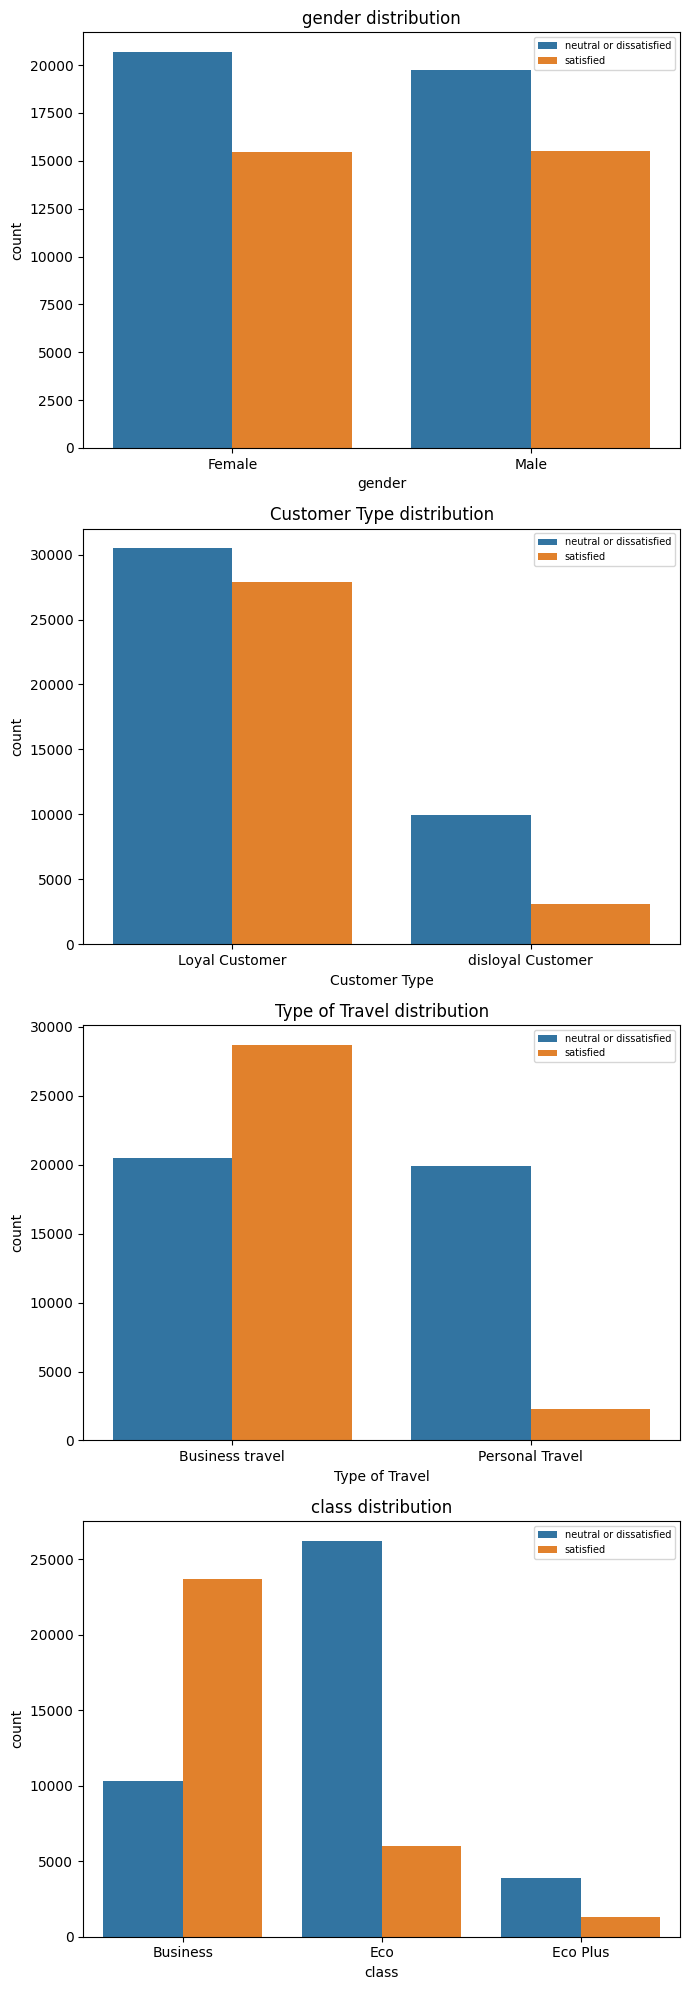

In [315]:
plot_categorical(categorical_cols, X_train, y_train)

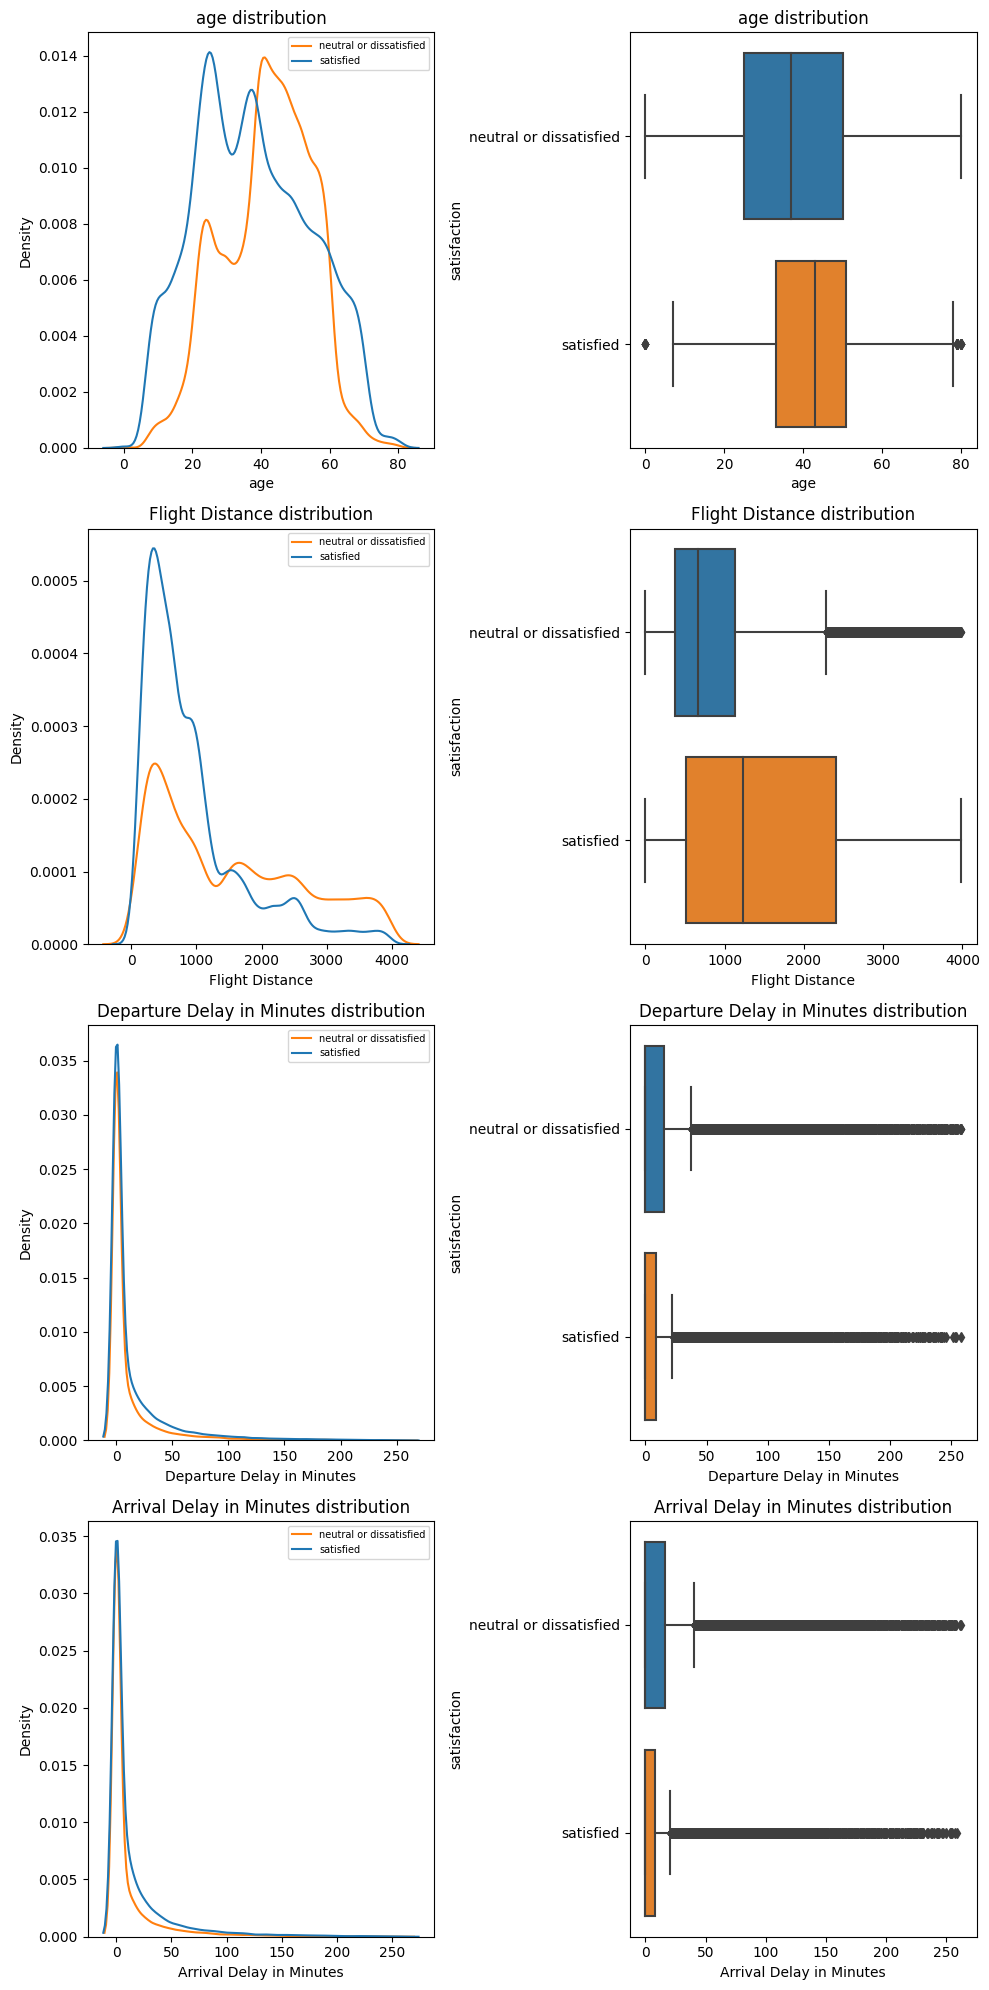

In [316]:
plot_continuous(continuous_cols, X_train, y_train)

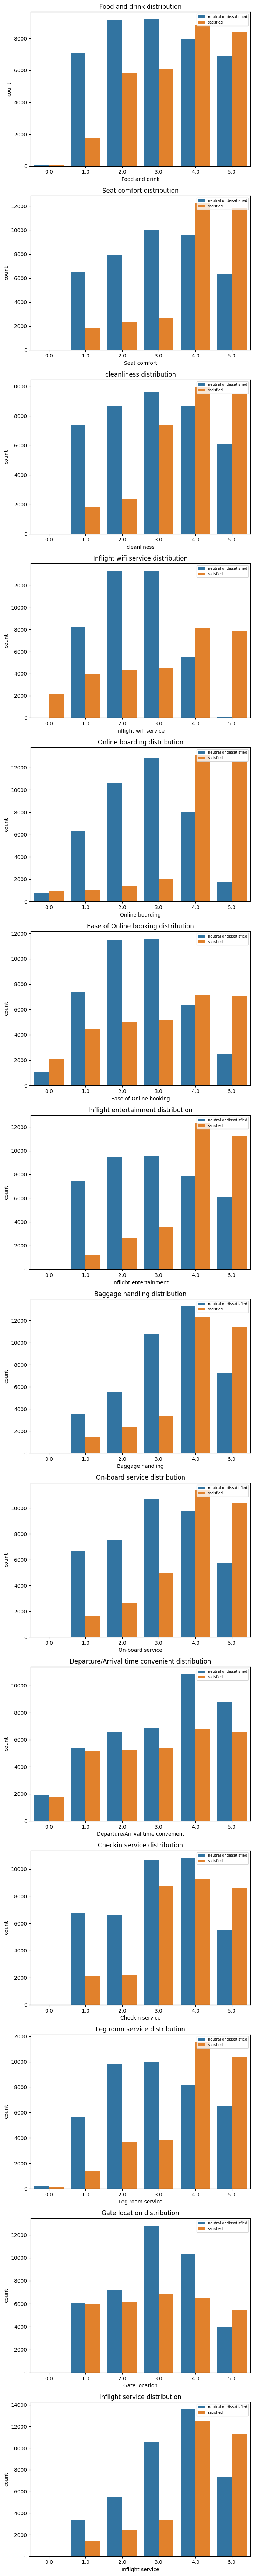

In [317]:
plot_ordinal(ordinal_cols, X_train, y_train)

Text(0.5, 1.0, 'Target distribution')

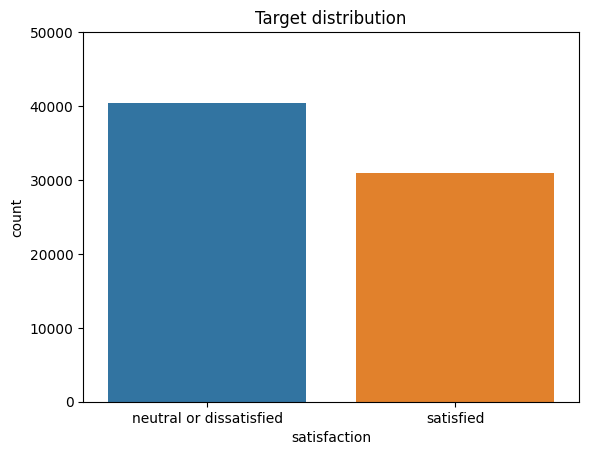

In [318]:
# visualize y_train
sns.countplot(x=y_train)
plt.ylim(0, 50000)
plt.title('Target distribution')

<font color='#FF6600'>Сделайте выводы по построенным графикам</font>. Полезно было бы упомянуть:
* какие признаки распределены неравномерно
* сбалансированы ли классы
* какие распределения имеют континуальные признаки

__Вывод:__  
- Дисбаланс классов совсем небольшой
- Распределение порядковых признаков само по себе неравномерно, оно больше похоже на нормальное
- Распределение категориальных признаков также неравномерно
- Континуальные признаки имеют около нормальное скошенное распределение, также некоторые признаки имеют распрелелние похожее на нормальное, но с несколькими вершинами

In [319]:
# your answer her
# feel free to change this cell from code to markdown

(Бонус: 0.25 балла) <font color='#9933CC'>По графикам (каким, решите сами) оцените, похожи ли оказались распределения признаков при разбиении на трейн, валидацию и тест </font>

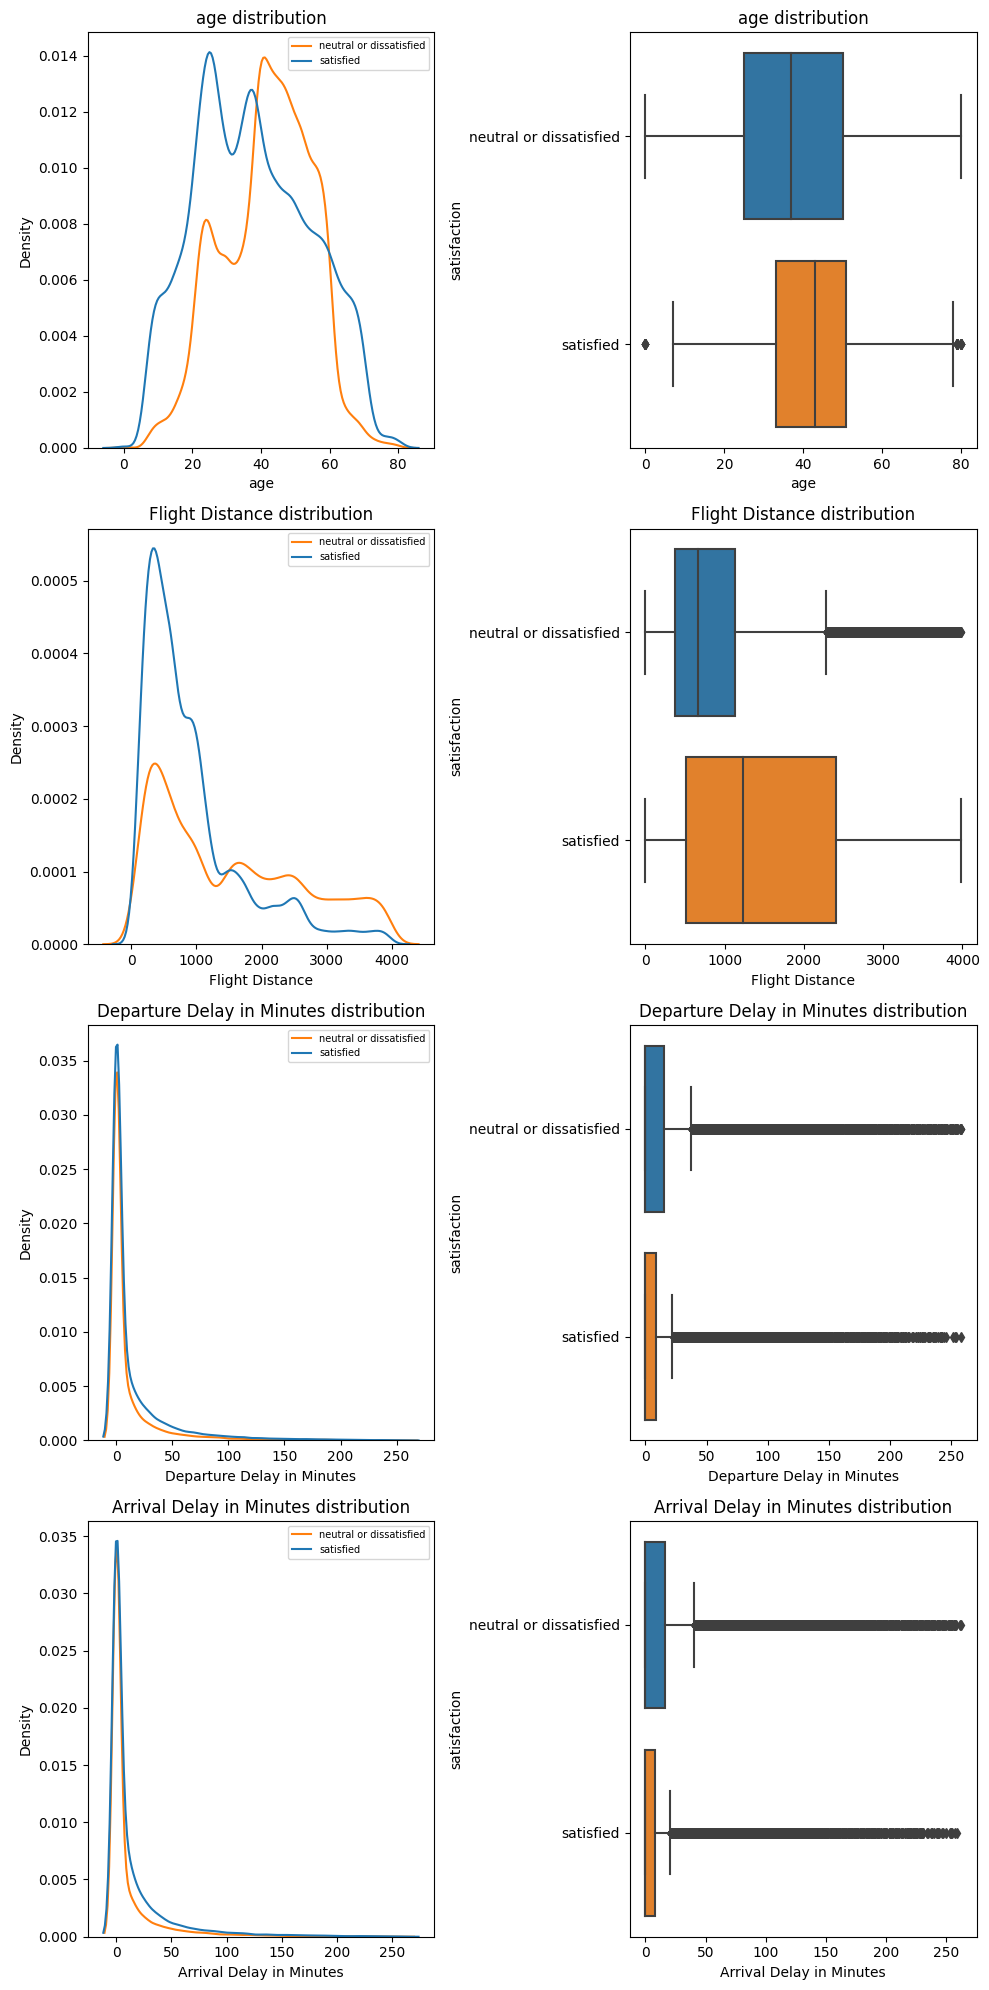

In [320]:
# your code below
plot_continuous(continuous_cols, X_train, y_train)

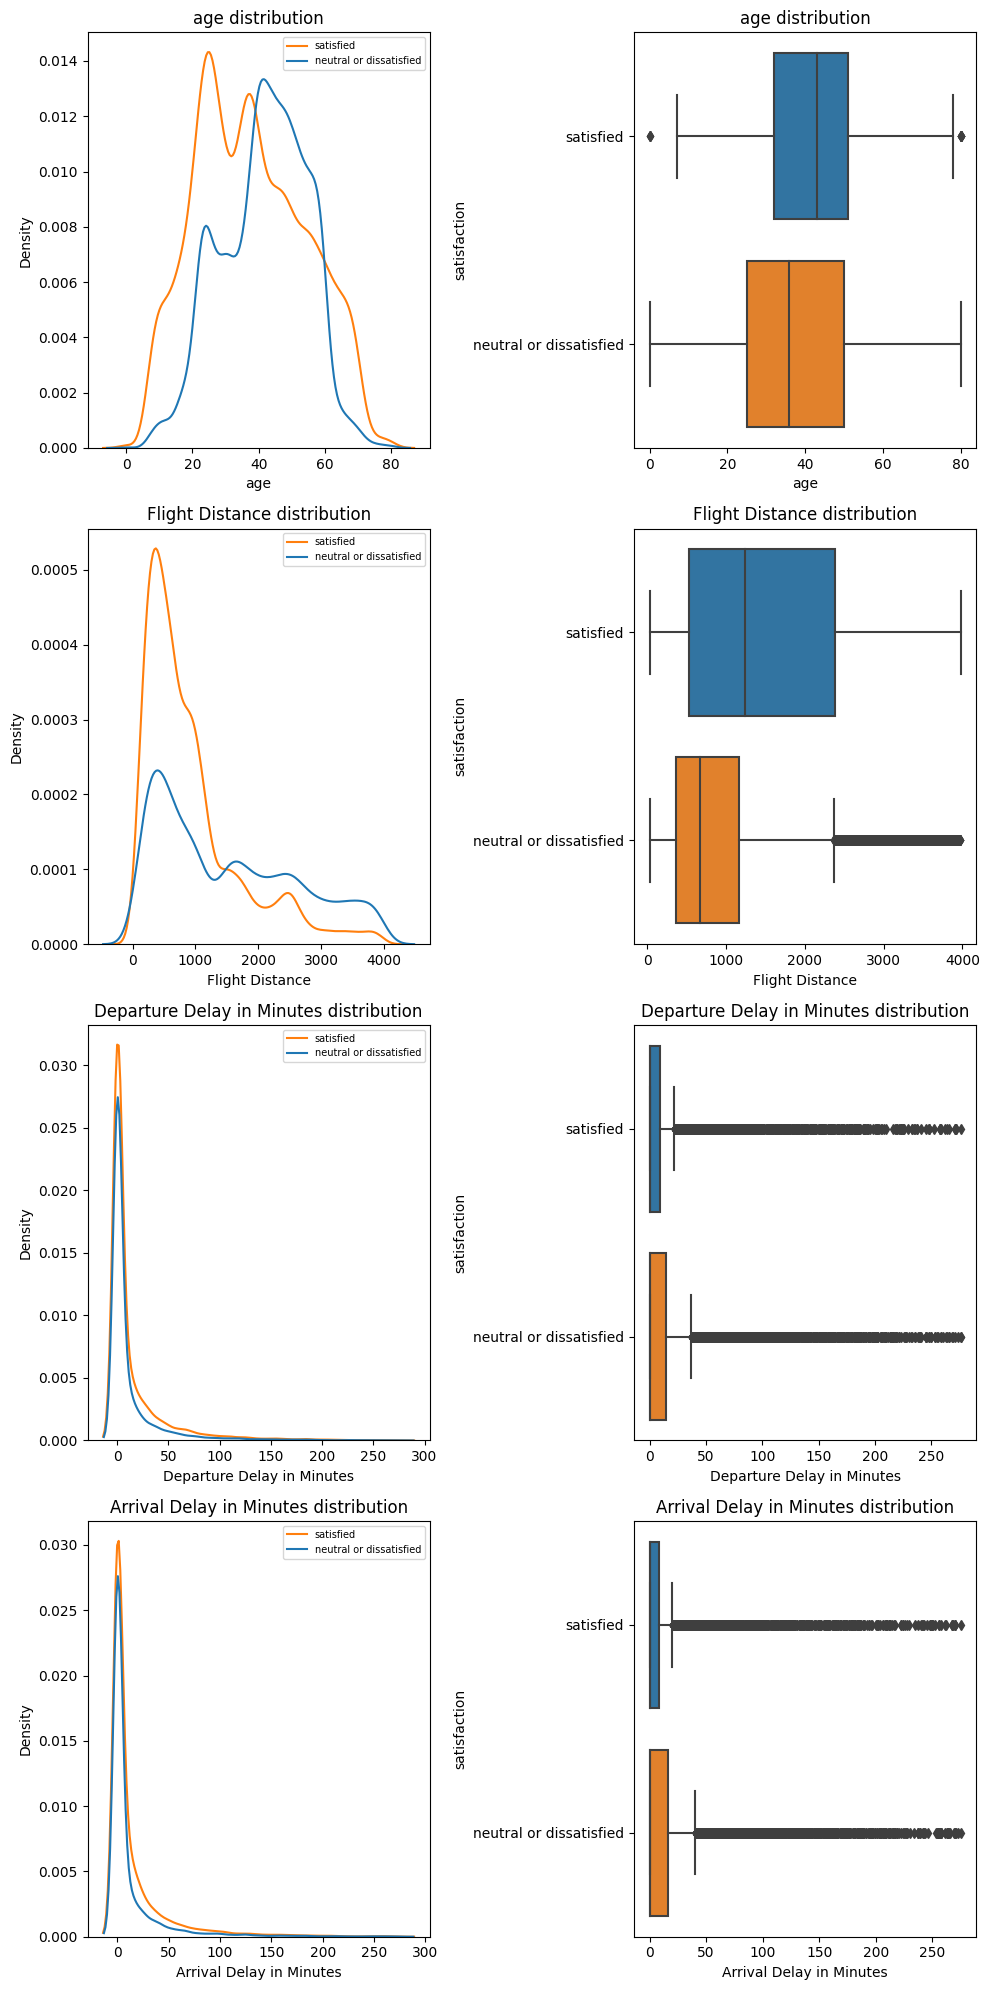

In [321]:
plot_continuous(continuous_cols, X_val, y_val)

__Вывод:__  
На примере распределения признака age можно увидеть, что их графики схожи, есть только различия в кол-ве объектов, из-за которых присутствуют незначительные отклонения.

(0.25 балла) Давайте <font color='#9933CC'>заменим признаки "Departure Delay in Minutes" и "Arrival Delay in Minutes" на их логарифмы.</font>

In [322]:
# your code
X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = X_train[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].apply(lambda x: np.log(x + 0.000001))
X_val[['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = X_val[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].apply(lambda x: np.log(x + 0.000001))
df_test[['Departure Delay in Minutes', 'Arrival Delay in Minutes']] = df_test[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].apply(lambda x: np.log(x + 0.000001))


Теперь заново <font color='#9933CC'>постройте графики континуальных признаков</font>

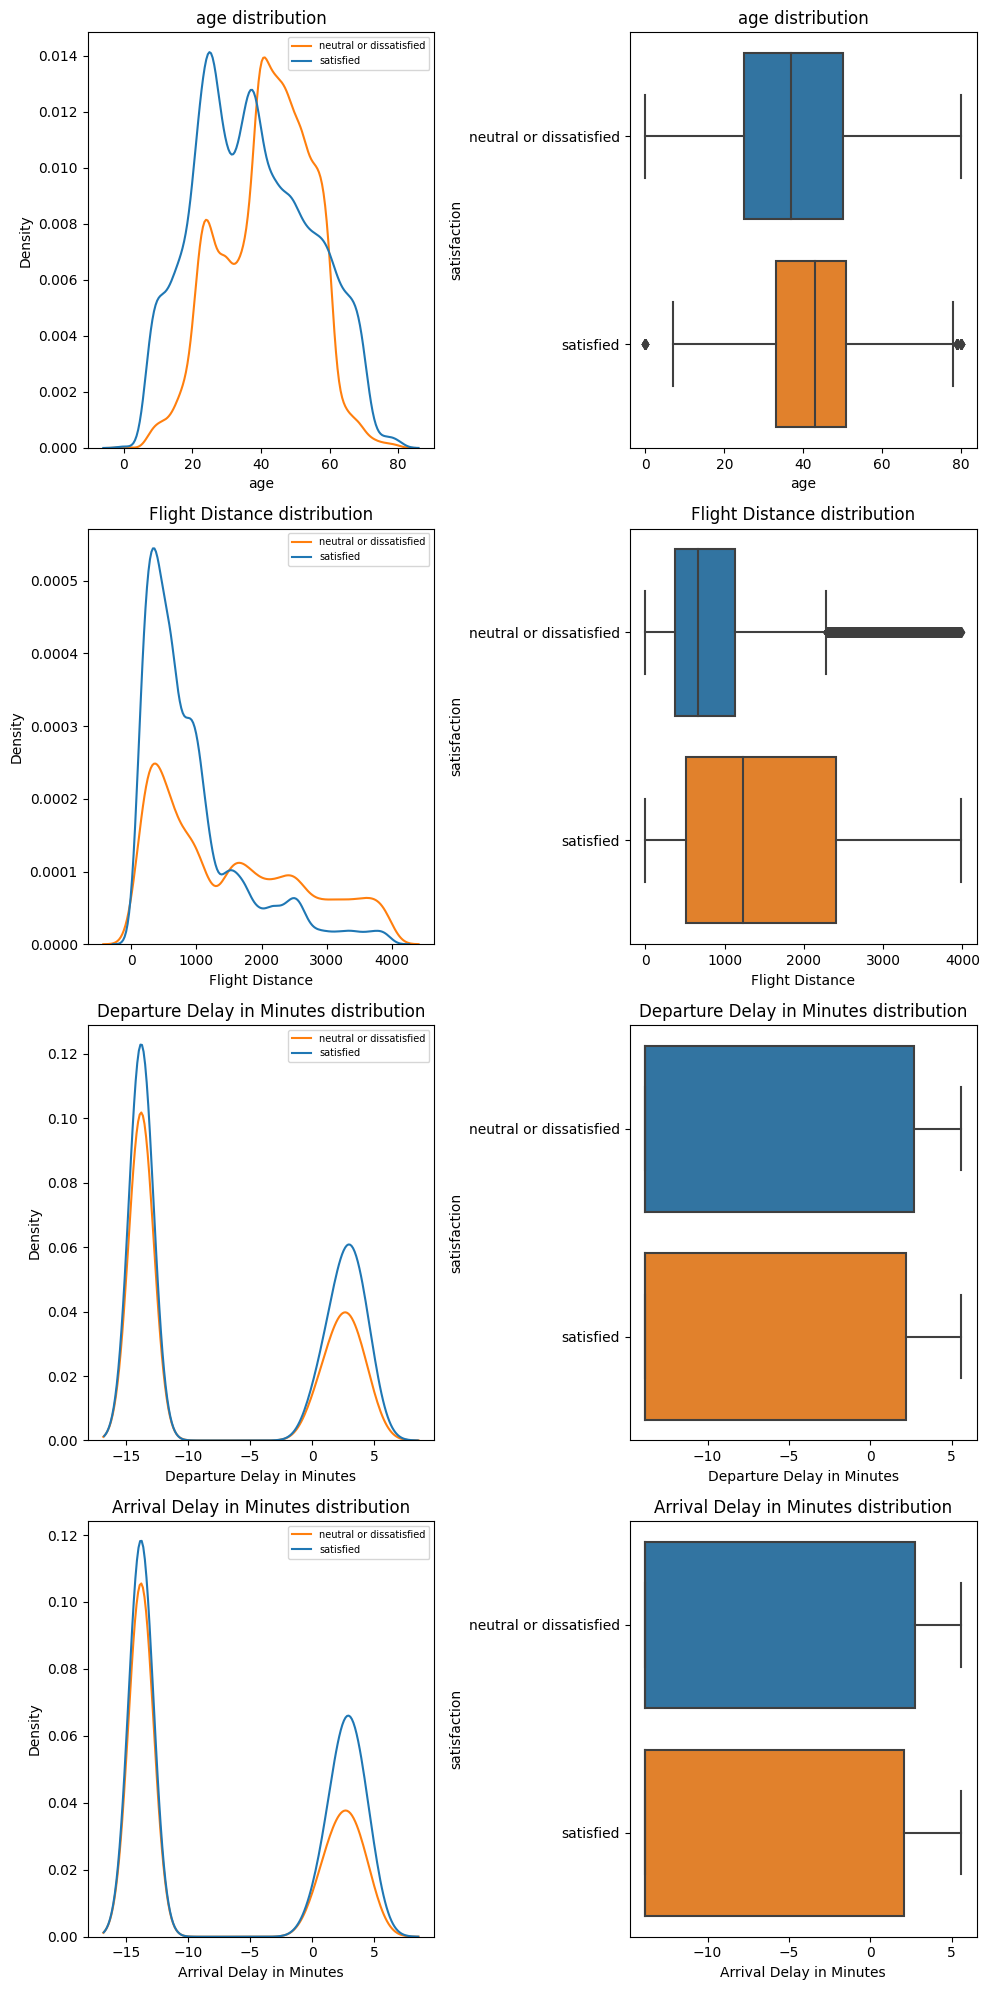

In [323]:
plot_continuous(continuous_cols, X_train, y_train)

<font color='#9933CC'>Закодируйте таргет таким образом, чтоб 'satisfied' перешел в 1, а остальные значения в 0</font>

In [324]:
# your code
dict_replace = {'neutral or dissatisfied': 0, 'satisfied': 1}
y_train = y_train.replace(dict_replace)
y_val = y_val.replace(dict_replace)

In [325]:
y_train.value_counts()

0    40395
1    30974
Name: satisfaction, dtype: int64

(0.25 балла) <font color='#9933CC'>Отобразите попарное распределение континуальных (по договоренности) признаков. Покрасьте точки на pairplot'е в соответствии с их классом</font>. Наблюдений много, так что отрисовка графика вполне может занять несколько минут

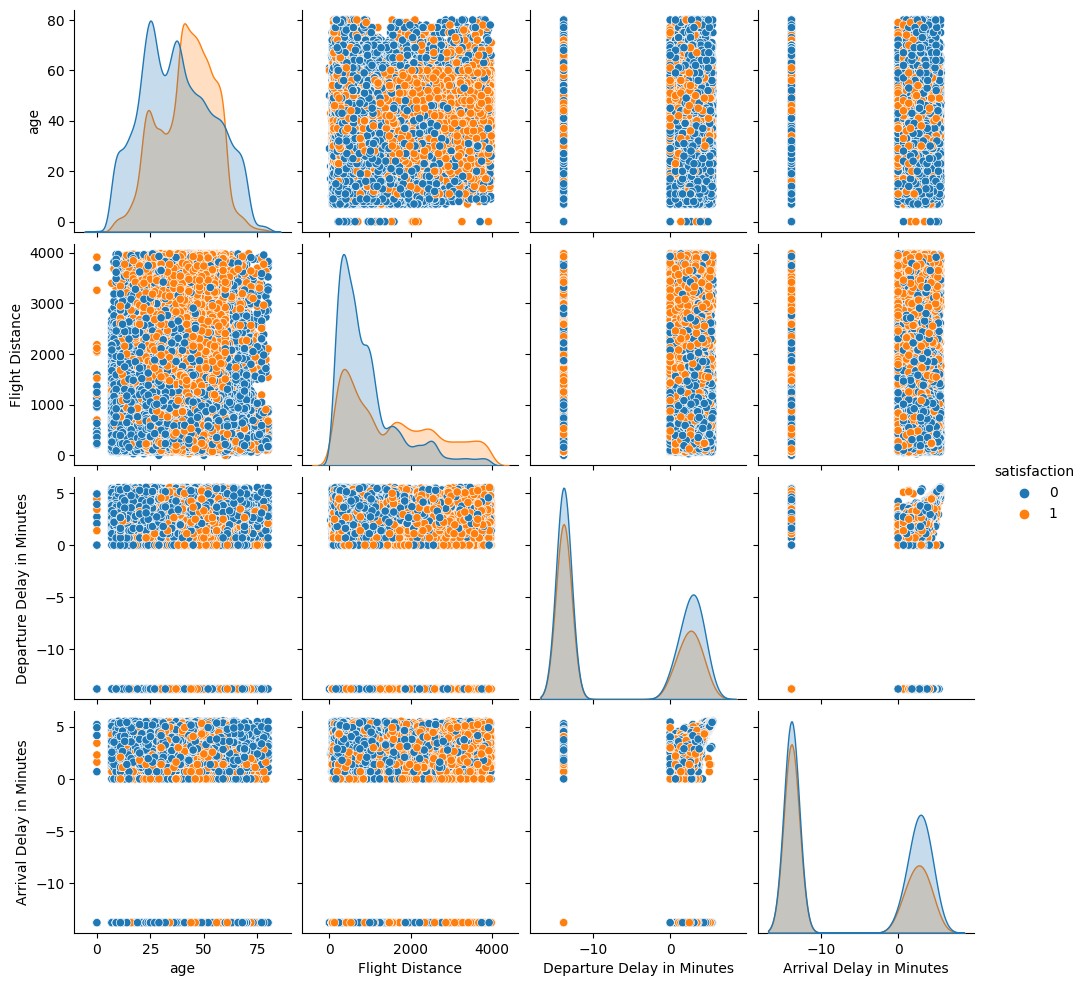

In [326]:
# your code
sns.pairplot(data=X_train[continuous_cols].reset_index(drop=True).join(y_train.reset_index(drop=True)), hue='satisfaction', kind='scatter', diag_kind='kde')

# Decision Tree (3 балла)

(0.5 балла) <font color='#9933CC'>Закодируйте категориальные признаки методом OHE</font>. Для дерева используйте гиперпараметры по умолчанию.

In [327]:
# your code below

encoder = OneHotEncoder(drop='first', handle_unknown='ignore')
encoder.fit(X_train[categorical_cols])

X_train.reset_index(drop=True, inplace=True)
X_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

X_train_cat_hot_only = pd.DataFrame.sparse.from_spmatrix(
    encoder.transform(X_train[categorical_cols]),
    columns=encoder.get_feature_names_out()
    )

X_val_cat_hot_only = pd.DataFrame.sparse.from_spmatrix(
    encoder.transform(X_val[categorical_cols]),
    columns=encoder.get_feature_names_out()
    )

df_test_cat_hot_only = pd.DataFrame.sparse.from_spmatrix(
    encoder.transform(df_test[categorical_cols]),
    columns=encoder.get_feature_names_out()
    )

X_train = X_train.drop(categorical_cols, axis=1).join(X_train_cat_hot_only)
X_val = X_val.drop(categorical_cols, axis=1).join(X_val_cat_hot_only)
df_test = df_test.drop(categorical_cols, axis=1).join(df_test_cat_hot_only)

<font color='#9933CC'>Обучите дерево решений с параметрами по умолчанию на имеющихся данных.</font> Здесь и далее везде, где вас просят что-нибудь обучить, выводите `accuracy_score` для валидационной подвыборки

In [328]:
y_train.reset_index(drop=True, inplace=True)

In [329]:
# code here
model_tree_1 = DecisionTreeClassifier()
model_tree_1.fit(X_train, y_train)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


DecisionTreeClassifier()

In [330]:
pred_model_tree_1 = model_tree_1.predict(X_val)
accuracy_score(y_val, pred_model_tree_1)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


0.9428599431539744

## Деревья решений. Теоретическая вставка

(0.5 балла) <font color='#9933CC'>Посчитайте bias и variance для построенного дерева.</font> Для этого проще всего вспользоваться функцией `bias_variance_decomp()` из модуля mlxtend. Используйте '0-1_loss'

In [332]:
# change *params into what needs to be there by task condition
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
   	model_tree_1, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val),
    	loss='0-1_loss')
print(f"Average expected loss: {avg_expected_loss.round(3)}")
print(f"Average bias: {avg_bias.round(3)}")
print(f"Average variance: {avg_var.round(3)}")

Average expected loss: 0.061
Average bias: 0.039
Average variance: 0.044


## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>Выведите на экран barplot, демонстрирующий оценки важности признаков</font>

<Axes: >

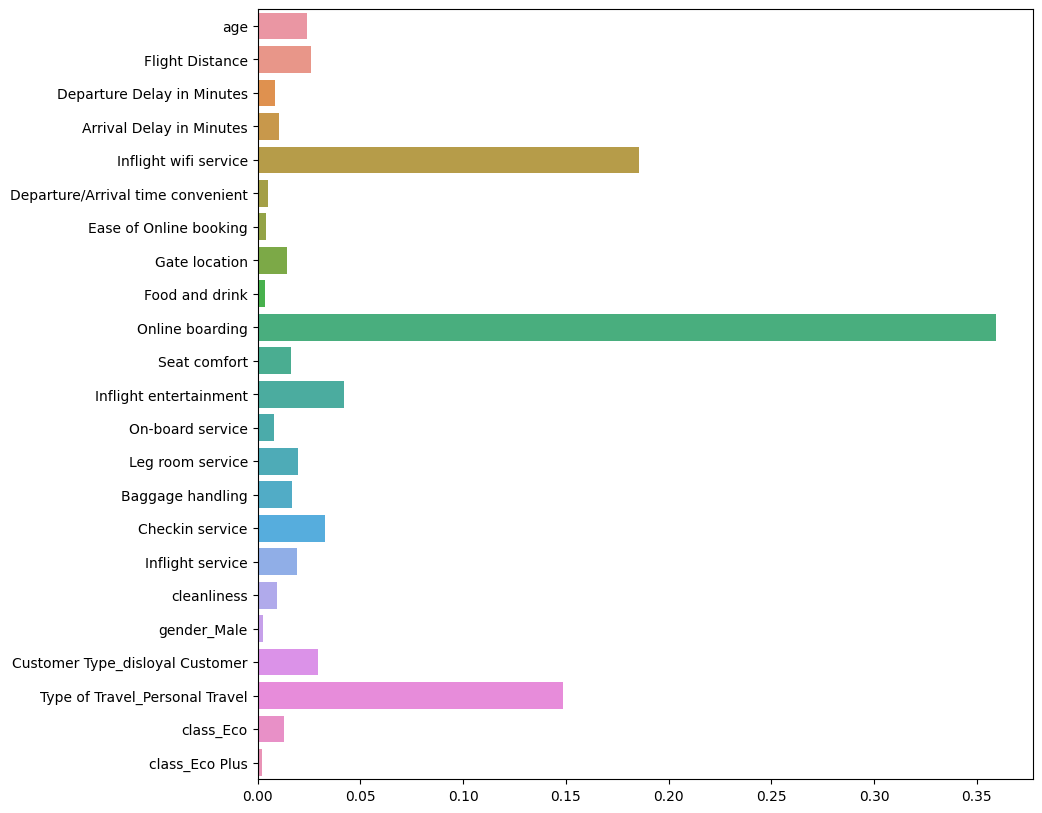

In [336]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x=model_tree_1.feature_importances_, y=X_train.columns)

<font color='#FF6600'>Какие признаки оказались наиболее информативными?</font>

In [337]:
X_train.columns

Index(['age', 'Flight Distance', 'Departure Delay in Minutes',
       'Arrival Delay in Minutes', 'Inflight wifi service',
       'Departure/Arrival time convenient', 'Ease of Online booking',
       'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
       'Inflight entertainment', 'On-board service', 'Leg room service',
       'Baggage handling', 'Checkin service', 'Inflight service',
       'cleanliness', 'gender_Male', 'Customer Type_disloyal Customer',
       'Type of Travel_Personal Travel', 'class_Eco', 'class_Eco Plus'],
      dtype='object')

__Ответ:__  
Самые информативные признаки:
- Inflight wifi service
- Online boarding
- Type of Travel_Personal Travel

<font color='#9933CC'>Какой глубины получилось дерево? Сколько в нем листьев?</font>

In [339]:
model_tree_1.get_depth()

31

In [340]:
model_tree_1.get_n_leaves()

2030

<font color='#9933CC'>Постройте дерево глубины 5, используя только 2 наиболее информативных признака для предыдущего построенного дерева</font>. <font color='#FF6600'>Насколько упало качество на тесте?</font>

In [341]:
# the place for your solution
model_tree_2 = DecisionTreeClassifier(max_depth=5)
model_tree_2.fit(X_train[['Inflight wifi service', 'Online boarding']], y_train)

pred_model_tree_2 = model_tree_2.predict(X_val[['Inflight wifi service', 'Online boarding']])
accuracy_score(y_val, pred_model_tree_2)

0.8217517723545362

__Ответ:__  
Качество просело на 0.12 пунктов

(0.25 балла) <font color='#9933CC'>С помощью graphviz постройте получившееся дерево решений</font>. <font color='#FF6600'>Почему предикаты в нем не целые, а кратны 1/2?</font>

In [343]:
import graphviz

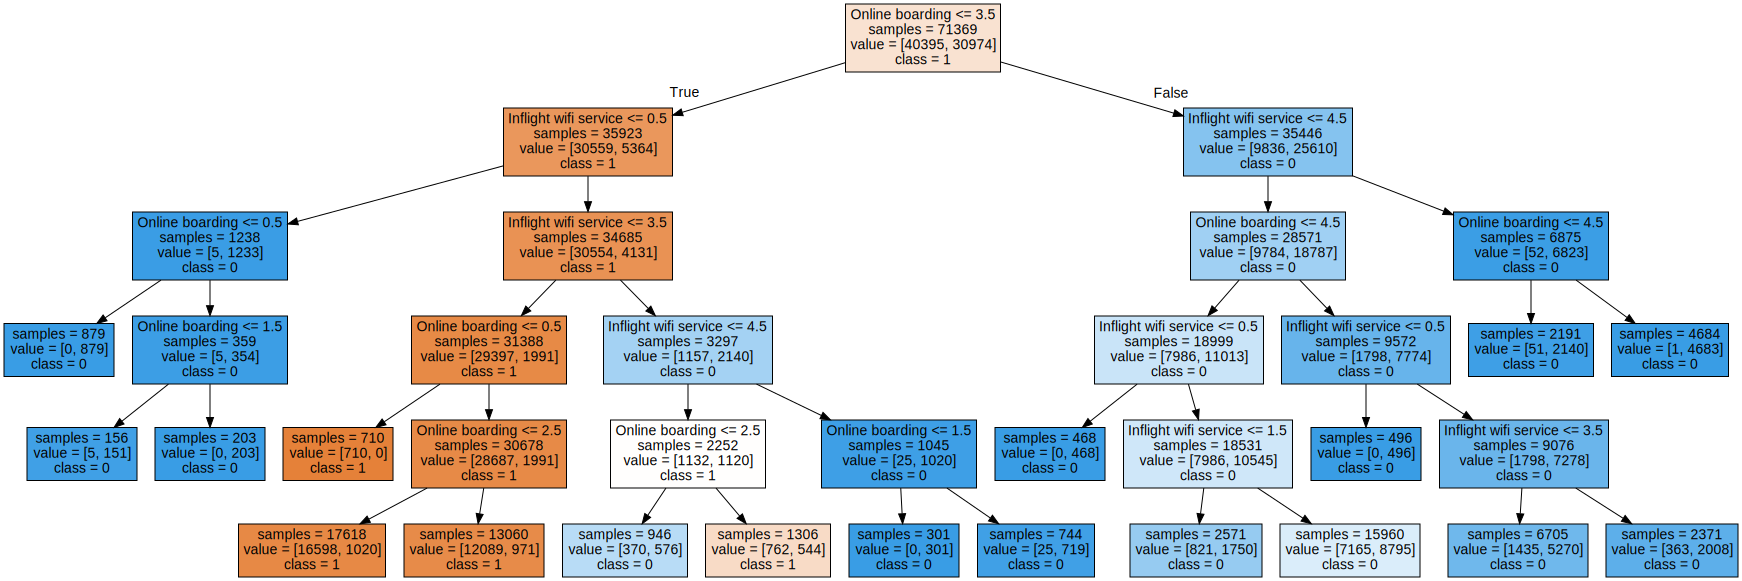

In [347]:
# feel free to google
# from sklearn.tree import export_graphviz
export_graphviz(
    model_tree_2,
    out_file="tree.dot",
    class_names=['1', '0'],
    feature_names=['Inflight wifi service', 'Online boarding'],
    impurity=False,
    filled=True
    )

with open("tree.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

__Ответ:__  
Предикаты кратны 0.5, так как признаки, на которых построено дерево - целочисленные, а кратность 0.5 позволяет сделать среднее, между соседними значениями порядкового признака.

<font color='#9933CC'>Теперь постройте дерево той же глубины 5 для 2-х наиболее информативных континуальных (по договорённости) признаков</font>

In [350]:
# your code below
# the place for your solution
model_tree_3 = DecisionTreeClassifier(max_depth=5)
model_tree_3.fit(X_train[['age', 'Flight Distance',]], y_train)

pred_model_tree_3 = model_tree_3.predict(X_val[['age', 'Flight Distance',]])
accuracy_score(y_val, pred_model_tree_3)

0.6809108432160476

(0.25 балла) <font color='#9933CC'>Отобразите его функцией `plot_tree()` из sklearn</font>. <font color='#FF6600'>Симметричным ли получилось дерево? Это хорошо или плохо?</font>

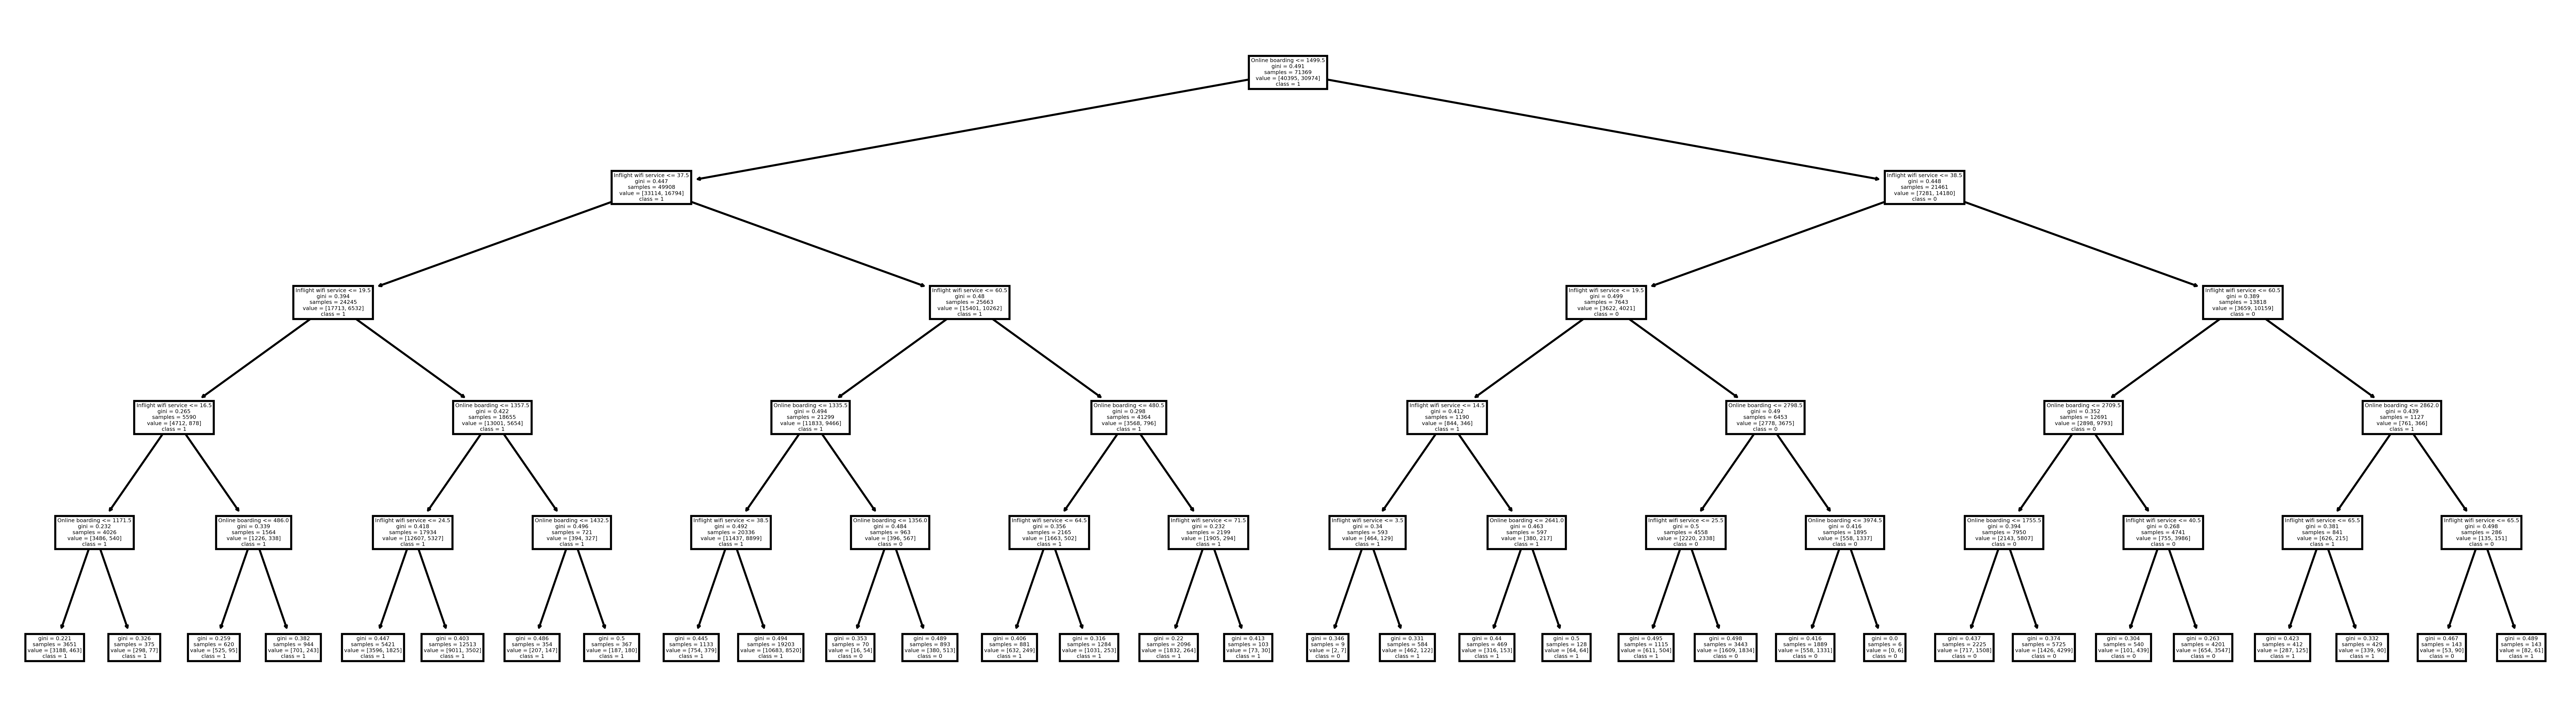

In [363]:
# another place to code a few lines
ax, fig = plt.subplots(1, 1, figsize=(22, 6), dpi=700)
plot_tree(model_tree_3, class_names=['1', '0'], feature_names=['Inflight wifi service', 'Online boarding'])
plt.show()

__Ответ:__  
Дерево получилось симметричным

(0.5 балла) <font color='#9933CC'>Используя функцию `plot_decision_regions()` из `mlxtend`, отобразите разделяющую поверхность получившегося дерева.</font> Отметьте на графике только первые 100 объектов обучающей выборки

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


<Axes: >

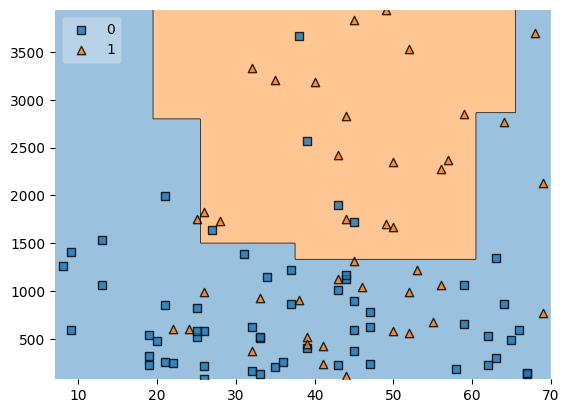

In [371]:
# your line of code
plot_decision_regions(np.array(X_train[['age', 'Flight Distance',]])[:100, :], np.array(y_train)[:100], clf=model_tree_3, legend=2)

## Деревья решений. Теоретическая вставка 2

Из лекций вам должно быть известно, что деревья решений неустойчивы даже к небольшим изменениям в обучающей выборке. Попробуем показать это

X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names
X does not have valid feature names, but DecisionTreeClassifier was fitted with feature names


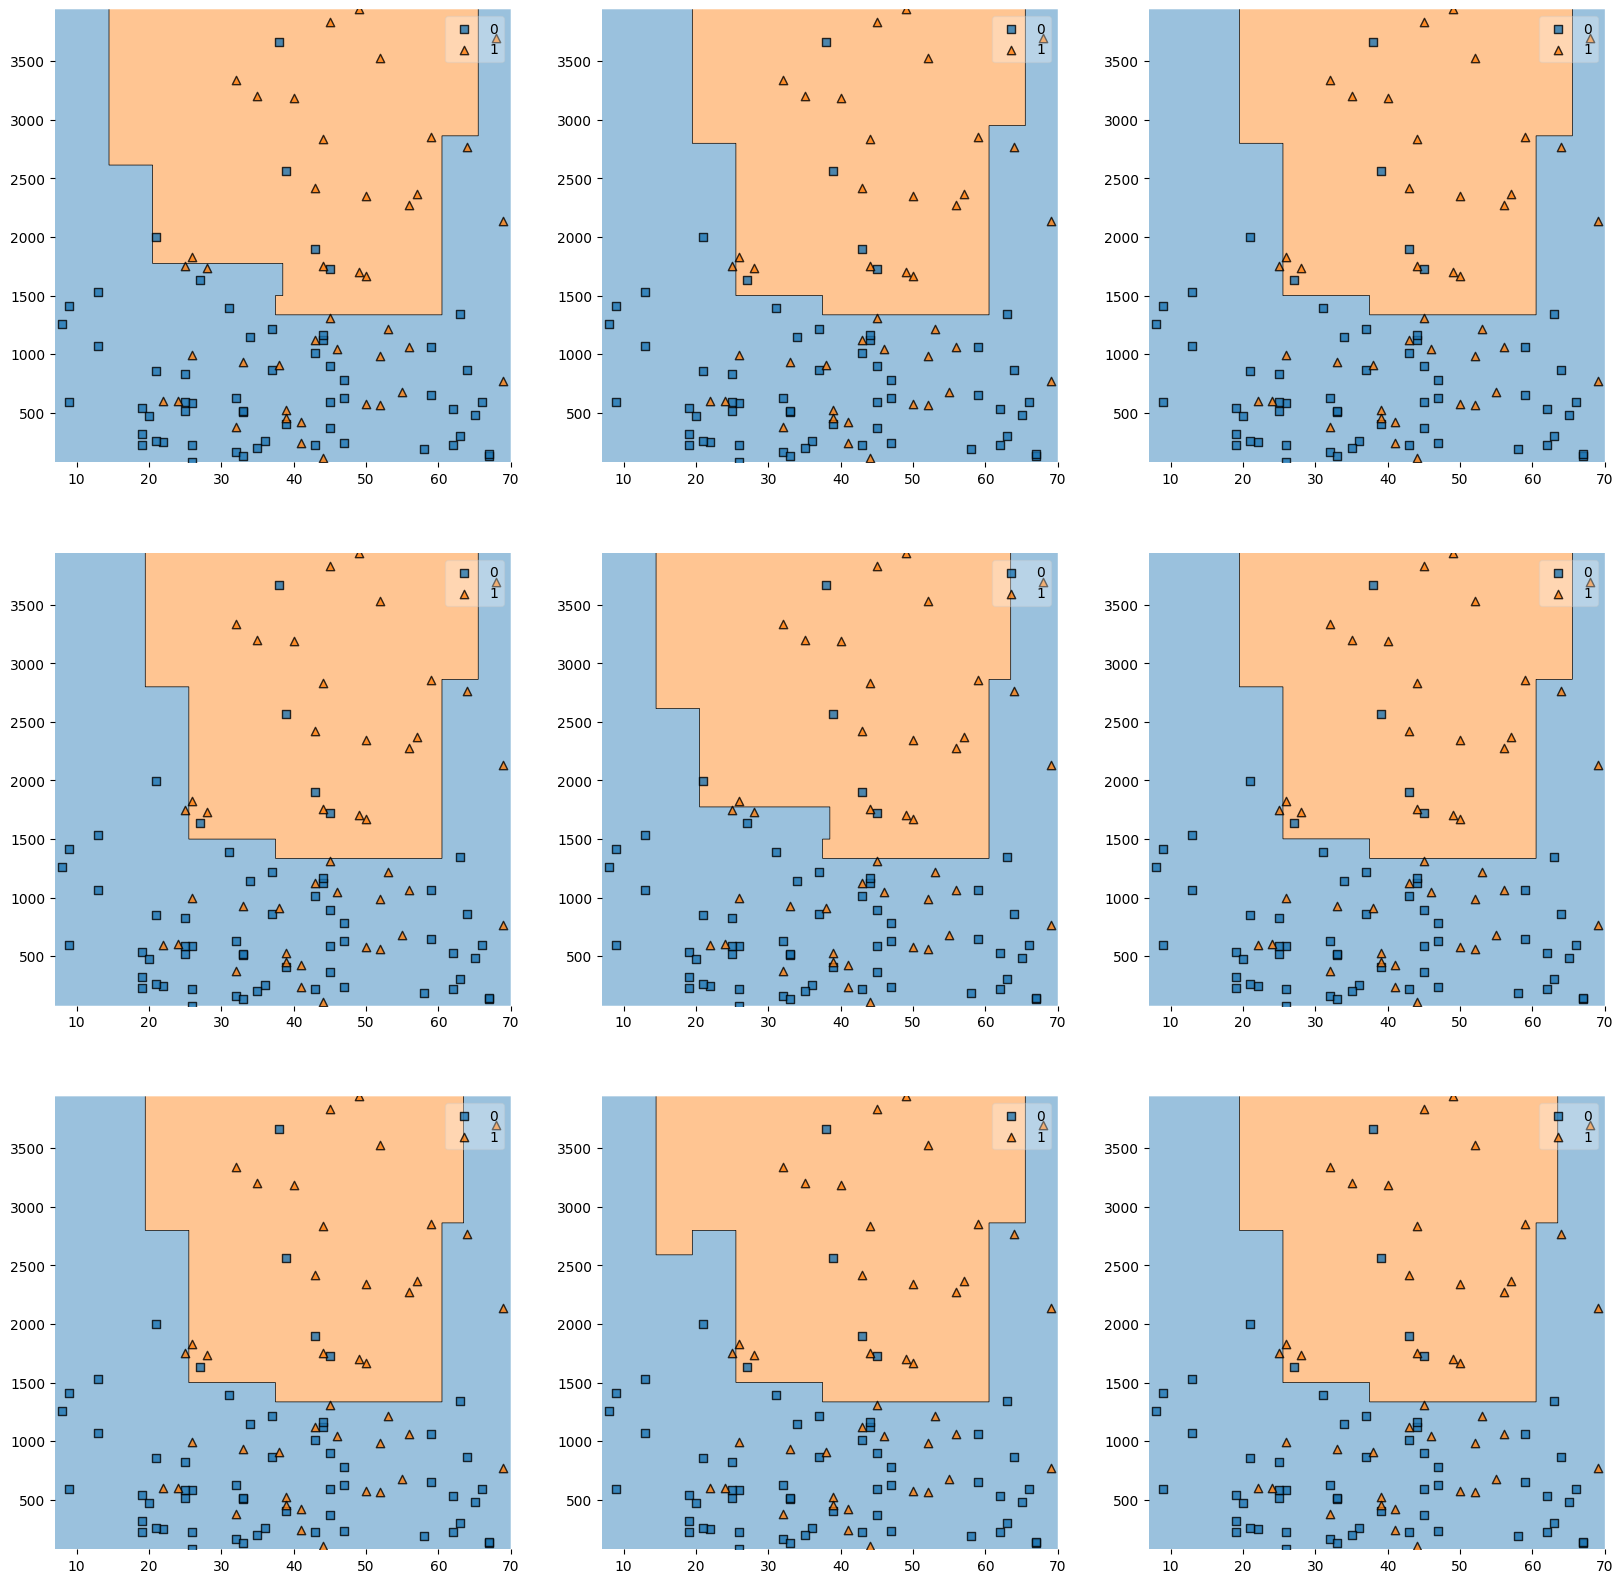

In [395]:
# change X_train_example to your equivalent
X_train_example = X_train[['age', 'Flight Distance']].copy()


fig, ax = plt.subplots(3, 3, figsize=(20, 20))

for row in range(3):
    for col in range(3):
        inds = np.random.choice(X_train_example.index, size=X_train_example.shape[0] - 1000, replace=False) # нагляднее брать не на 1к, а на 5к меньше объектов, а то почти не изменяется разделяющая поверхность

        tree_exp = DecisionTreeClassifier(max_depth=5, random_state=42)
        tree_exp.fit(X_train_example.loc[inds, :], y_train[inds])

        plot_decision_regions(clf=tree_exp, X=np.array(X_train_example.iloc[:100, :]), y=np.array(y_train[:100]), ax=ax[row][col])

Мы убирали из трейна (а в нем ~80к наблюдений) всего по тысяче случайных объектов!

Помимо своей неусточивости деревья решений "славны" ещё и склонностью к переобучению. Посмотрим, можно ли увидеть это свойство на имеющихся у нас данных. Для этого будем обучать алгоритм DT на всем трейне с разной глубиной дерева и считать accuracy для теста

In [397]:
import time

In [399]:
%%time
# change X_train_enc into your ohe-encoded train set
X_train_enc = X_train.copy()
X_val_enc = X_val.copy()

depths = [2, 3, 5, 10, 15, 20, 25, 32, 50, 64, 75, 100]

accuracies_train = []
accuracies_test = []
for max_depth in depths:
    DT = DecisionTreeClassifier(max_depth=max_depth, random_state=42)
    DT.fit(X_train_enc, y_train)
    y_predicted_train = DT.predict(X_train_enc)
    y_predicted_val = DT.predict(X_val_enc)
    accuracies_train.append(accuracy_score(y_train, y_predicted_train))
    accuracies_test.append(accuracy_score(y_val, y_predicted_val))

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

CPU times: user 7.15 s, sys: 15.5 ms, total: 7.16 s
Wall time: 11.7 s


pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


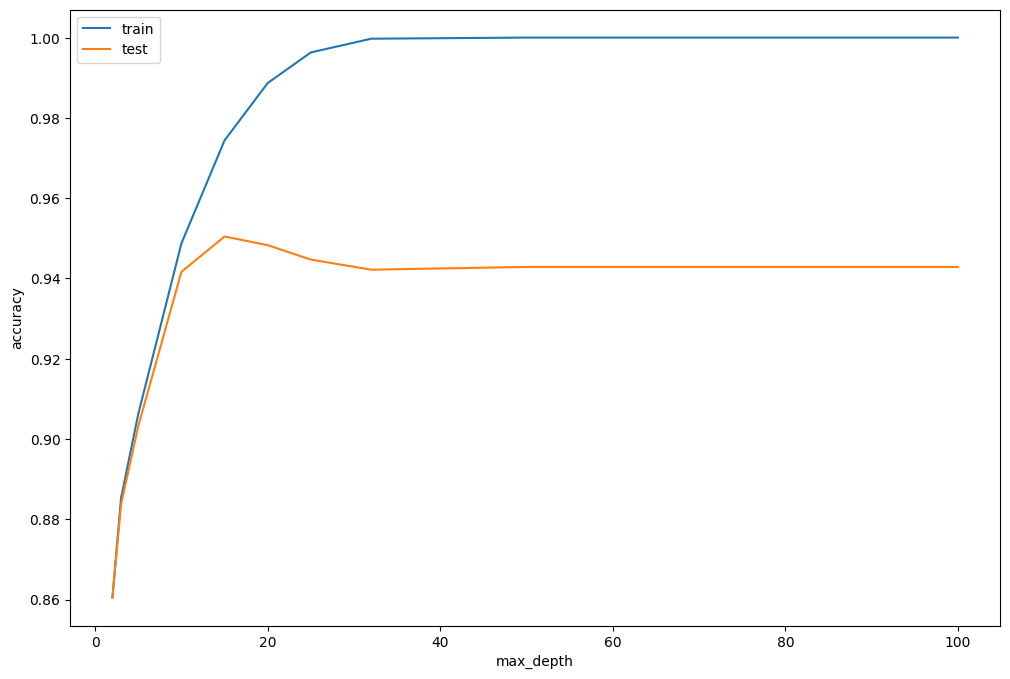

In [400]:
plt.figure(figsize=(12, 8))
plt.plot(depths, accuracies_train, depths, accuracies_test)
plt.legend(['train', 'test'])
plt.ylabel('accuracy')
plt.xlabel('max_depth')
plt.show()

Нам повезло выйти на ассимптоту на тесте. Однако так бывает далеко не всегда. Так что подбирать гипрепараметры для деревьев решений стоит осторожно

## Возвращение к задаче

(0.5 балла) <font color='#9933CC'>На кроссвалидации подберите оптимальные гиперпараметры для дерева решений</font> *(по данным со всеми признаками -- не на модельном примере из теоретической вставки)*. <font color='#FF6600'>Удалось ли улучшить качество предсказаний подбором гиперпараметров?</font>

In [401]:
# you know what to do

tree_params = {'max_depth': range(10,20), 'criterion': ['gini', 'entropy', 'log_loss']}

tree_grid = GridSearchCV(DecisionTreeClassifier(), tree_params, cv=5, n_jobs=-1, verbose=True)
tree_grid.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': range(10, 20)},
             verbose=True)

In [402]:
pred_model_tree_grid = tree_grid.predict(X_val)
accuracy_score(y_val, pred_model_tree_grid)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


0.9507007742820739

In [403]:
0.9507007742820739 - 0.9428599431539744

0.007840831128099524

__Ответ:__  
Удалось повысить качество на 0.007840831128099524 пункта

<font color='#9933CC'> Сохраните лучшее дерево в pickle </font>

*Мы просим это сделать, чтобы вы в случае чего не тратили время на переобучение, а могли банально подгрузить из файла*

In [ ]:
with open('DT.pkl', 'wb') as f:
    pass

# Random Forest (4 балла)

<font color='#9933CC'>Обучите случайный лес с параметрами по умолчанию</font>

In [404]:
# -__-

rf_mpdel_1 = RandomForestClassifier()
rf_mpdel_1.fit(X_train, y_train)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


RandomForestClassifier()

In [405]:
pred_model_rf_mpdel_1 = rf_mpdel_1.predict(X_val)
accuracy_score(y_val, pred_model_rf_mpdel_1)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


0.9605998235812996

(0.75 балла) <font color='#9933CC'>Выведите калибровочную кривую для полученного ансамбля</font>

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


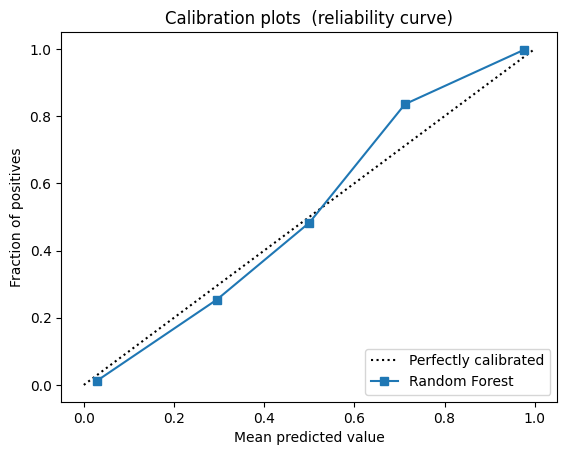

In [412]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

# # Применение калибровки
# calib_model = CalibratedClassifierCV(rf_mpdel_1, method='isotonic')
# calib_model.fit(X_train, y_train)
# prob_calib_model = calib_model.predict_proba(X_val)[:, 1]
prob_calib_model = rf_mpdel_1.predict_proba(X_val)[:, 1]
# Калибровочная кривая
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, prob_calib_model, n_bins=5)

# Построение графика
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ('Random Forest'))
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.show()

Похоже, мы немного недооцениваем высокие вероятности

<img src='https://habrastorage.org/r/w1560/getpro/habr/upload_files/510/4e0/63b/5104e063b62bd0ac6b87da44a3034aa5.png'>

Изображение взято из статьи ["predict_proba в Python не прогнозирует вероятности (и как с этим бороться)"](https://habr.com/ru/company/otus/blog/573924/) с Хабра

<font color='#FF6600'>Вспомните (или выведите), корректно ли деревья предсказывают вероятности?</font>

__Ответ:__  
Из-за своей структуры, деревья решений принимают решения на основе кусочно-постоянных приближений, что означает, что они не могут обеспечить гладкость или непрерывность в предсказаниях.

<font color='#9933CC'>Обучите логистическую регрессию с параметрами по умолчанию и отобразите её калибровочную кривую</font>

UPD: не с параметрами по умолчанию, а так, чтоб сошлась

In [419]:
log_reg = LogisticRegression(max_iter=5000)
log_reg.fit(X_train, y_train)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


LogisticRegression(max_iter=5000)

In [420]:
pred_model_log_reg = log_reg.predict(X_val)
accuracy_score(y_val, pred_model_log_reg)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


0.8741546603940018

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


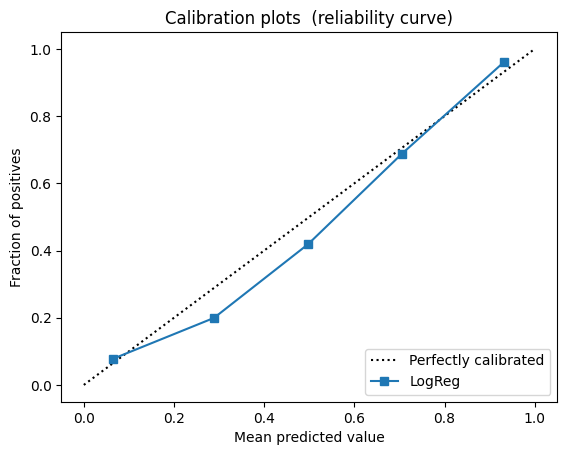

In [421]:
# --____--

prob_calib_model = log_reg.predict_proba(X_val)[:, 1]
# Калибровочная кривая
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, prob_calib_model, n_bins=5)

# Построение графика
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ('LogReg'))
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.show()

Мы немного переоцениваем предсказанные низкие вероятности

<font color='#FF6600'>Покажите, почему считается, что логистическая регрессия корректно предсказывает вероятности?</font>

 __Ответ:__  
На данном графике видно, что логистическая регрессия не переоценивает высокие вероятности, а приближает их к идеальным.  
При использовании логистической регрессии для предсказания вероятностей, модель обучается таким образом, чтобы максимизировать «правдоподобие» наблюдаемых данных, что ведет к оценкам вероятностей, которые хорошо соответствуют реальным данным.

(0.75 балла) <font color='#9933CC'>Предлагаем вам попробовать откалибровать вероятности обученного случайного леса</font>. Для этого воспользуйтесь логистической и изотонической регрессиями. <font color='#FF6600'>Интерпретируйте полученные результаты</font>

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

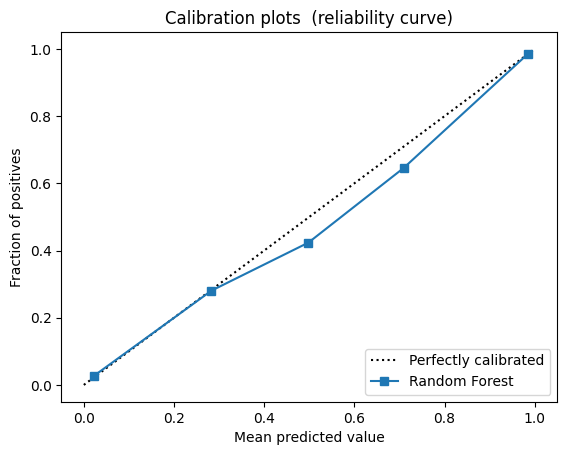

In [423]:
# # Применение калибровки
calib_model = CalibratedClassifierCV(rf_mpdel_1, method='sigmoid')
calib_model.fit(X_train, y_train)
prob_calib_model = calib_model.predict_proba(X_val)[:, 1]

# Калибровочная кривая
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, prob_calib_model, n_bins=5)

# Построение графика
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ('Random Forest sigmoid calibrated'))
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.show()

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

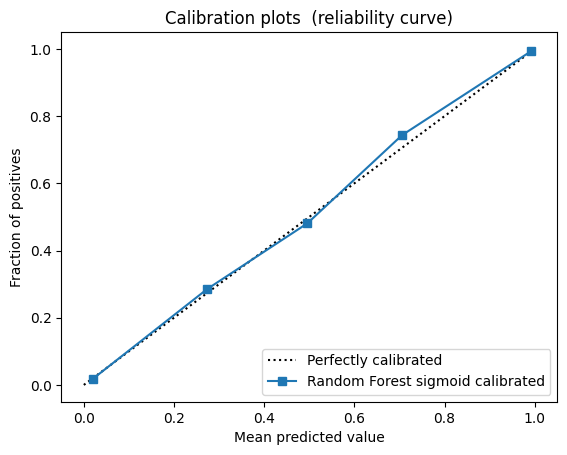

In [424]:
# # Применение калибровки
calib_model = CalibratedClassifierCV(rf_mpdel_1, method='isotonic')
calib_model.fit(X_train, y_train)
prob_calib_model = calib_model.predict_proba(X_val)[:, 1]

# Калибровочная кривая
fraction_of_positives, mean_predicted_value = calibration_curve(y_val, prob_calib_model, n_bins=5)

# Построение графика
plt.figure()
plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
plt.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s" % ('Random Forest sigmoid calibrated'))
plt.ylabel("Fraction of positives")
plt.xlabel("Mean predicted value")
plt.legend(loc="lower right")
plt.title('Calibration plots  (reliability curve)')
plt.show()

<font color='#FF6600'>Опишите другие возвожные подходы к калбировке вероятностей (со ссылками на источники)</font>

__Ответ:__  
Калибровки веротяностей, например калиьрока Платто.  
https://habr.com/ru/articles/648753/



(1 балл) <font color='#9933CC'>Посчитайте разброс и смещение полученного случайного леса (до калибровки).</font><font color='#FF6600'>Оличаются ли они от полученных для дерева решений? Соответствуют ли полученные на реальных данных отличия (//совпадения) от тех, что должны быть в теории? По каким причинам?</font>

In [425]:
# one more place for your code

avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
   	rf_mpdel_1, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val),
    	loss='0-1_loss')
print(f"Average expected loss: {avg_expected_loss.round(3)}")
print(f"Average bias: {avg_bias.round(3)}")
print(f"Average variance: {avg_var.round(3)}")

Average expected loss: 0.042
Average bias: 0.04
Average variance: 0.01


Значения для дерева (чтобы вспомнить)  
Average expected loss: 0.061  
Average bias: 0.039  
Average variance: 0.044  

__Ответ:__  
- Значения для случайного леса отличаются от тех, что были в дереве(выше вставка).
- Разницу можно объяснить тем, что как раз таки random forest (бэггинг с доработками) уменьшает variance, а bias оставяет на том же уровне, поэтому лучше обучать его на глубоких деревьях.
- Значения, которые должны быть в теории на реальных данных получить практически невозможно, так как в реальной жизни невозможно восстановить распределение, для которого мы делаем предсказания.

<font color='#9933CC'>Вычислите разложение ошибки для логистической регрессии (ванильной, не той, что использовали для калибровки).</font> <font color='#FF6600'>Сравните полученные результаты с предыдущими. Объясните природу этих результатов</font>

In [426]:
# (•_•)
avg_expected_loss, avg_bias, avg_var = bias_variance_decomp(
   	log_reg, np.array(X_train), np.array(y_train), np.array(X_val), np.array(y_val),
    	loss='0-1_loss')
print(f"Average expected loss: {avg_expected_loss.round(3)}")
print(f"Average bias: {avg_bias.round(3)}")
print(f"Average variance: {avg_var.round(3)}")

Average expected loss: 0.126
Average bias: 0.126
Average variance: 0.005


Скопировал на всякий, потому что оно считалось 1 час 15 минут)))  
Average expected loss: 0.126  
Average bias: 0.126  
Average variance: 0.005

__Ответ:__  
- В сравнении с результатами случайного леса: видим, что смещение здесь намного больше, это и не удивительно, сам алгоритм наш получился менее качественным (accuracy меньше на 0.1 практически).
- Также очень маленький разброс у данного алгоритма, потому что у алгоритмов, которые разделяют классы при помощи построения гиперплоскости, изменения в перемещении (при изменении выборки) этой гиперплоскости минимальною

(1 балл) <font color='#9933CC'>Попробуйте подобрать оптимальные гиперпараметры, используя `RandomizedSearchCV`</font>. Хотя бы один из гиперпараметров перебирайте из распределения (например, `uniform` из `scipy.stats`)

In [431]:
# your code here
# делаю простенький, иначе не дождусь)))
from scipy.stats import uniform
from scipy.stats import randint

param_dist = {
    'max_depth': randint(25, 50, 1),
    'criterion': ['gini', 'entropy']
}

# Создаем RandomizedSearchCV
random_search = RandomizedSearchCV(RandomForestClassifier(), param_distributions=param_dist, n_iter=10, cv=3, random_state=42)

# Обучаем модель
random_search.fit(X_train, y_train)

# Выводим лучшие параметры
print(random_search.best_params_)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
pandas.DataFrame with sparse col

{'criterion': 'gini', 'max_depth': 36}


In [432]:
pred_model_random_search = random_search.predict(X_val)
accuracy_score(y_val, pred_model_random_search)

pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.


0.9610898755268058

## Случайный лес. Вставка теории

На модельном примере посмотрим, склонен ли случайный лес к переобучению с ростом числа деревьев в композиции.

Возьмем 4 полезных признака из одного из предыдщущих заданий, напоминающих теорию

In [433]:
# change X_train_enc into you equivalent
X_train_enc = X_train.copy()

cols_for_RF = ['age', 'Flight Distance', 'Online boarding', 'Inflight wifi service']
X_train_RF = X_train_enc[cols_for_RF]
# а тест нам не понадобится, ведь можно получить OOB-estimate ошибки

clf = RandomForestClassifier(warm_start=True, oob_score=True, random_state=42)
errors = []

for n_estimators in range(1, 251, 5):
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train_RF, y_train)

    errors.append(1 - clf.oob_score_)

Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.
Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable OOB estimates.


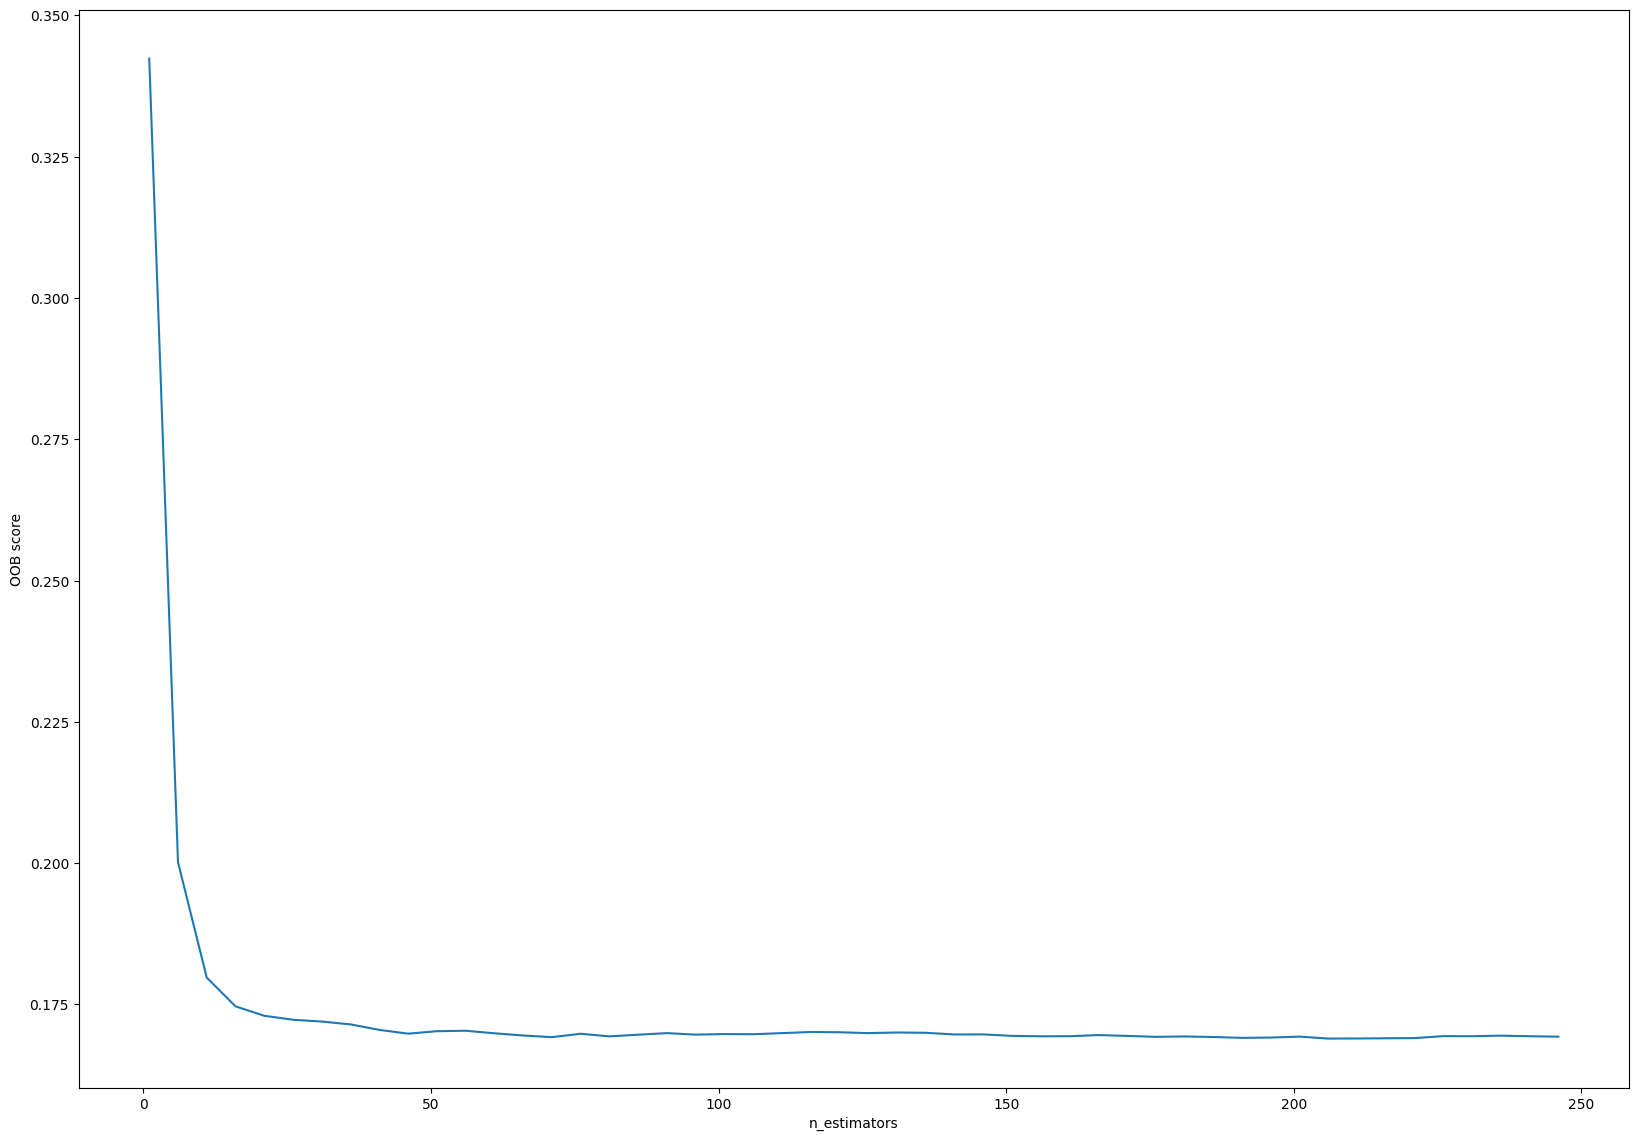

In [435]:
plt.figure(figsize=(20, 14))
plt.plot(range(1, 251, 5), errors)

plt.xlabel('n_estimators')
plt.ylabel('OOB score')
plt.show()

> **Дисклеймер**: отсутствие переобучения с ростом числа деревьев вовсе не означает, что сама модель случайного леса не может быть переобучена. Базовые деревья такой композиции могут переобучаться. Значит, и вся композиция вполне способна оказаться переобученной

## Возвращение к задаче

<font color='#9933CC'>Отобразите `feature_importances_` вашего лучшего случайного леса</font>

<Axes: >

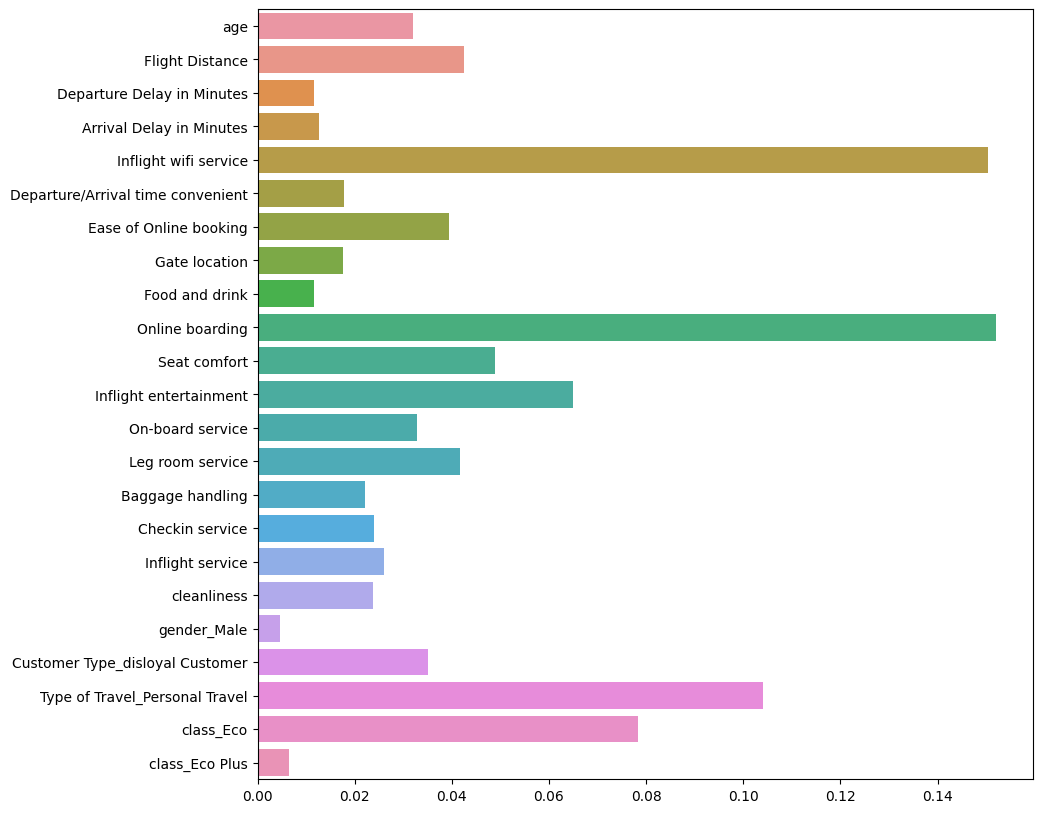

In [476]:
# (•_•)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(x=random_search.best_estimator_.feature_importances_, y=X_train.columns)

(0.5 балла) <font color='#9933CC'>Сравните важности признаков для дерева решений и для случайного леса. Постройте диаграмму</font>

In [456]:
tree_feat_imp = list(model_tree_1.feature_importances_)
rf_feat_imp = list(random_search.best_estimator_.feature_importances_)
columns_plot = list(X_train.columns)
models = ['DecTree' for i in range(len(tree_feat_imp))]

columns_plot = columns_plot + columns_plot
tree_feat_imp = tree_feat_imp + rf_feat_imp
models = models + ['RandForest' for i in range(len(rf_feat_imp))]

In [458]:
models_comparison = {
    'features': columns_plot,
    'values': tree_feat_imp,
    'model': models
    }

models_comparison_df = pd.DataFrame().from_dict(models_comparison)
models_comparison_df['values'] = models_comparison_df['values'].astype(float)

<Axes: xlabel='values', ylabel='features'>

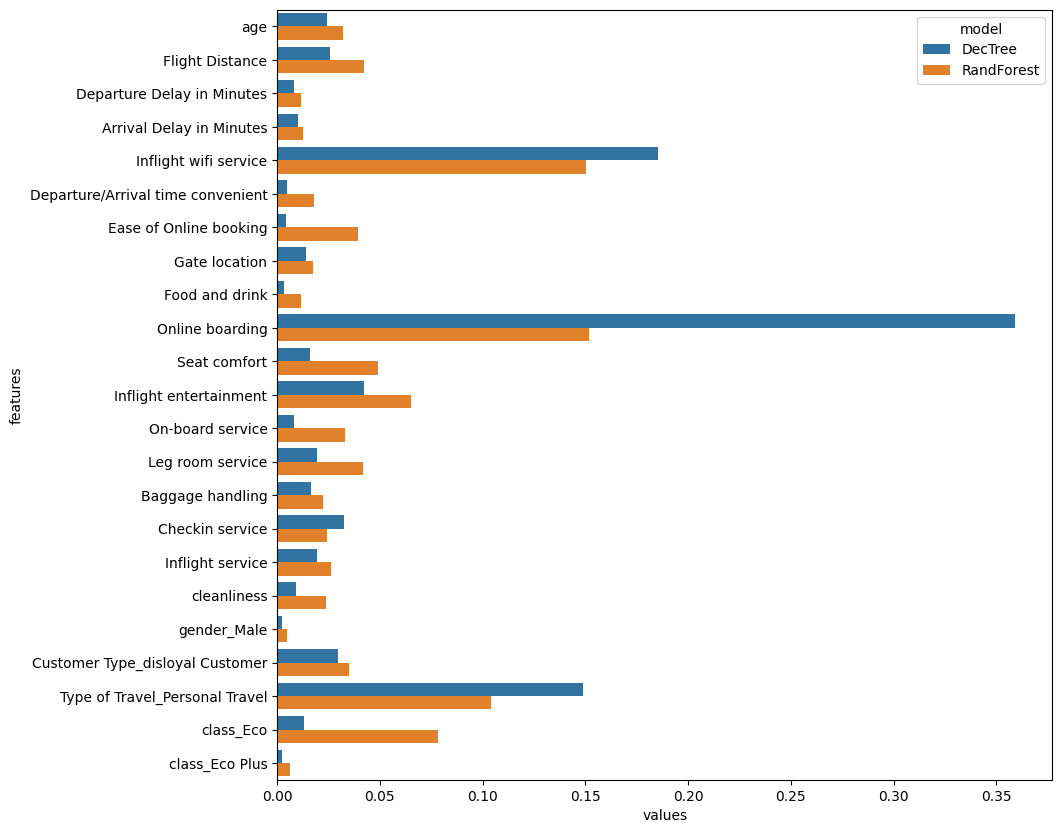

In [460]:
# -__-
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
sns.barplot(data=models_comparison_df, x='values', y='features', hue='model')

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью SHAP</font>. Для подсчета используйте 1000 случайных объектов, иначе не дождетесь за приемлемое время

[Статья "Интерпретация моделей и диагностика сдвига данных: LIME, SHAP и Shapley Flow"](https://habr.com/ru/company/ods/blog/599573/) из блога ods.ai на Хабре

In [477]:
# (•_•)
subset = X_train.loc[np.random.choice(X_train.shape[0], 1000, replace=False)]
shap.initjs()
explainer = shap.TreeExplainer(random_search.best_estimator_)
shap_values = explainer.shap_values(subset)
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], subset.iloc[0,:])

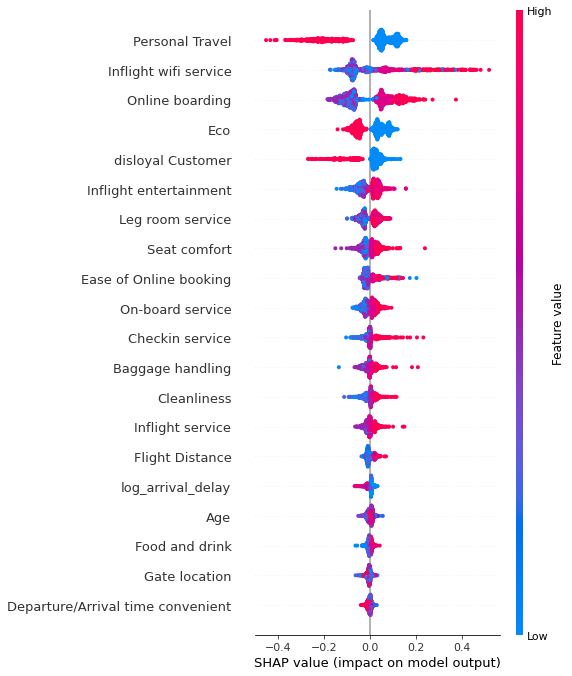

CPU times: user 5min 45s, sys: 2.77 s, total: 5min 47s
Wall time: 5min 45s


<font color='#FF6600'>Опишите полученый график</font>

__Ответ:__  
- На данном графике видно, что признак Personal Travel делает  большой вклад в результат классификации, так как случаи личной поездки приносят больше удовлетворения клиенту, чем рабочие в среднем.  
- Признаки Eco и Disloyal Customer также четко делят на классы.
- По признаку inflight wi-fi service можем увидеть, что чем выше его значение, тем более точно можно будет отнести клиента к положительному классу. Со многими другими признаками ситуация похожая.

<font color='#FF6600'>Изучите документацию библиотеки SHAP. Что ещё полезного в ней имеется? </font>

__Ответ:__   
Например, shap.plots.force, с помощью нее мы можем посмотреть на конкретный объект, как не предсказание для него повлияли какие-то фичи. В случае с уже построенной хорошей моделью это может оказаться полезно для бизнеса, чтобы например составить портрет клиента, что больше всего влияет на его поведение.

Бонус (0.5 балла) <font color='#9933CC'>Интерпретируйте важности признаков с помощью LIME</font>

In [497]:
import lime
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=X_train.columns, class_names=[1, 0], discretize_continuous=True)

# Выбор случайного примера из тестового набора
i = np.random.randint(0, X_train.shape[0])
exp = explainer.explain_instance(X_train.values[i, :], random_search.best_estimator_.predict_proba, num_features=5, top_labels=1)

# Вывод важности признаков
exp.show_in_notebook(show_table=True)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


<font color='#FF6600'>Опишите полученый график</font>

__Ответ:__  
- На данном графике видно, что больше всего вклада принесли фичи inflight wifi и type of travel, они склоняли в сторону отрицательного класса.
- На данном объекте прдесказание очень уверенное (видимо клиент оценил вайфай в полете очень низко и тип путешествия у него был не по личным нуждам, а по работе), влияние этих двух сильных признаков дает нам уверенное предсказание.

<font color='#9933CC'>Случайное лес, дающий лучший скор, сохраните в pickle</font>

In [ ]:
pass

# Обратная связь

Расскажите, как вам это домашнее задание. Было ли оно полезным? Научились ли вы чему то? Насколько сложным по 10-балльной шкале оно вам показалось? Сколько времени у вас ушло на его выполнение? Что следовало ещё в него включить? Было ли что-то лишнее?

- Все было классно, узнал много нового про возможности визуализации для интерпретации деревьев решений + увидел, как надо интерпретировать важность фичей.  

- Сложность = 6-7.  

- В целом все решаемо, но мне, как дата аналитику, нужно изучать много нового материала, чтобы корректно идти по домашней работе.  

- Времени = часов 10-12.

- Хотелось бы наверное в следующий раз бить такие домашки впополам может быть, чтобы не отклалывать одну большую на несколько дней.